# Главные классы

In [13]:
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator

class PCA_norm(PCA, BaseEstimator):
	"""
	Perform PCA and then normalize columns by singular values.
	"""
	def __init__(self, **kwargs):
		super().__init__(**kwargs)
		self.ones_koef = None

	def fit(self, X, y=None, **kwargs):
		super().fit(X, y, **kwargs)
		self.ones_koef = np.sqrt(X.shape[0])
		return self

	def transform(self, X, y=None):
		# Normalize the transformed data by singular values
		# PCA - перед SVD из столбцов вычитает среднее
		return np.hstack([np.ones((X.shape[0],1))/self.ones_koef, super().transform(X) / self.singular_values_]) 

	def fit_transform(self, X, y=None, **kwargs):
		# Fit PCA and apply transformation
		self.fit(X, y, **kwargs)
		return self.transform(X, y)


In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
import scipy.linalg as splin
from sklearn.linear_model import LogisticRegression

class QR_regression(BaseEstimator, ClassifierMixin):
	def __init__(self, FitClass=LogisticRegression, PredictClass=LogisticRegression, **kwargs):
		super().__init__()
		self.FitClass = FitClass
		self.PredictClass = PredictClass
		self.fit_model = FitClass(fit_intercept=False, penalty=None, **kwargs)
		self.predict_model = PredictClass(**kwargs)
		
	def fit(self, X, y): # sample_weight=None
		Q,R = np.linalg.qr(np.hstack([np.ones((X.shape[0],1)),X]))
		self.fit_model.fit(Q, y)
		w = (splin.solve_triangular(R, self.fit_model.coef_.T, lower=False)).T[0]
		#w = (np.linalg.inv(R)@Q_model.coef_.T).T[0]

		self.predict_model.coef_ = w[None,1:]
		self.predict_model.intercept_ = w[0:1]
		self.predict_model.classes_ = np.array([0, 1])

		return self

	def predict_proba(self, X):
		return self.predict_model.predict_proba(X)

	#def predict(self, X):
	#def decision_function(self, X):
	#def score(self, X, y, sample_weight=None):

In [52]:
from sklearn.base import BaseEstimator, ClassifierMixin
import scipy.linalg as splin
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

class normPCA_regression(BaseEstimator, ClassifierMixin):
	def __init__(self, regression=LogisticRegression, solver='lbfgs', tol=1e-8, center=0.5, threshold=1e-4, **kwargs):
		'''
		regression - любая регрессия

		долго (но не очень) ортогонализует и нормирует исходную выборку, а потом очень быстро учится на ней
		1) ортогонализует через PCA, потом берет середину спектра (center), умножает на threshold 
		и отбрасывает все компоненты, которые меньше получившейся величины
		2) нормирует то, что вернул PCA
		3) пересчитывает веса для исходной матрицы

		(c) Филя Усков
		'''
		super().__init__()
		self.regression = regression
		self.solver = solver
		self.tol = tol
		self.fit_model = regression(fit_intercept=False, penalty=None, solver=solver, tol=tol, **kwargs)
		self.predict_model = regression(fit_intercept=True, **kwargs)
		self.predict_model.classes_ = np.array([0, 1])

		self.center = center
		self.threshold = threshold

		
	def fit(self, X, y): # sample_weight=None
		"""
		y~f(X w) = f(Q S V^T w) = f(Q w')
		=> w = V S^{-1} w'
		"""
		pca = self.pca = PCA(n_components=None)
		Q_tmp = pca.fit_transform(X)

		center = self.center
		threshold = self.threshold
		mask = pca.singular_values_ > pca.singular_values_[int(len(pca.singular_values_)*center)]*threshold

		ones_koef = np.sqrt(X.shape[0])
		Q = np.hstack([np.ones((X.shape[0],1))/ones_koef, Q_tmp[:,mask] / pca.singular_values_[mask]]) 
		if np.abs(1-np.linalg.norm(Q[:,-1])) > 0.1:
			print('warning: threshold too small')

		# задать intercept_scaling 
		self.fit_model.fit(Q, y)

		self.predict_model.coef_ = ( pca.components_.T[:,mask] @ (self.fit_model.coef_.T[1:,:] / pca.singular_values_[mask,None])).T
		self.predict_model.intercept_ = self.fit_model.coef_[0,0]/ones_koef

		return self

	def predict_proba(self, X):
		return self.predict_model.predict_proba(X - self.pca.mean_)

	#def predict(self, X):
	#def decision_function(self, X):
	#def score(self, X, y, sample_weight=None):

In [ ]:
import torch
from torch import nn
import torch.optim as optim

class LogRegModel(nn.Module):
	def __init__(self, input_size, bias):
		"""
		Initialization of Linear Model
		:param input_size: int, dimension of input vector
		"""
		super(LogRegModel, self).__init__()
		self.layer = nn.Linear(input_size, 1, bias).to(device)

	def forward(self, x):
		p = torch.sigmoid(self.layer(x))
		return torch.hstack([p,1-p])

class TwoLayerModel(nn.Module):
    def __init__(self, input_size, hidden_size, bias):
        """
        Initialization of Linear Model
        """
        super(TwoLayerModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size, bias=bias).to(device)
        self.layer2 = nn.Linear(hidden_size, 1).to(device)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        p = torch.sigmoid(self.layer2(x))
        return torch.hstack([p,1-p])

def init(Model,*args,**kwargs):
	torch.manual_seed(0)
	return Model(*args,**kwargs)

def get_batch_indexes(n, batch_size):
	"""
	:param batch_size: int, batch size
	:param n: int, the size of full dataset
	:return: list of batches
	"""
	indexes = np.arange(n)
	#indexes = np.random.permutation(indexes)
	batches = np.array_split(indexes, n//batch_size)
	return batches


loss = nn.CrossEntropyLoss()

from sklearn.metrics import roc_auc_score
#print('roc_auc_score:',roc_auc_score(y_tst, model(Xc_tst)[:, 1].cpu().detach().numpy()))


class AttrDict(dict):
    def __getattr__(self, key):
        if key not in self:
            raise AttributeError(key) # essential for testing by hasattr
        return self[key]
    def __setattr__(self, key, value):
        self[key] = value
def make_dict(**kwargs):
    return AttrDict(kwargs)

def train1epoch(X_tr,y_tr,X_tst,y_tst,model,LR):
	optimizer = optim.SGD(model.parameters(),
							lr=LR,
							#momentum=args.momentum,
							#weight_decay=1/C
							)

	logs = make_dict(time_log=[],loss_log=[])

	t0 = time()
	batches = get_batch_indexes(X_tr.shape[0], 32)
	prog_bar = tqdm(enumerate(batches), total=len(batches))
	for i,batch in prog_bar:
		loss_value = loss(model(X_tr[batch]), y_tr[batch])
		loss_value.backward()
		optimizer.step()
		optimizer.zero_grad()

		if i==0:
			mean_loss = loss_value.item()
		mean_loss = 0.95*mean_loss + 0.05*loss_value.item()
		if i%32==0:
			logs.time_log.append(time()-t0)
			logs.loss_log.append(mean_loss)
			prog_bar.set_description(f'loss={mean_loss:.5}')

	with torch.torch.no_grad():
		logs.time = (time()-t0)

		y_pred = model(X_tr)
		logs.tr_loss = (loss(y_pred, y_tr).cpu().item())
		logs.tr_rocauc = (roc_auc_score(y_tr.cpu().detach().numpy(), y_pred[:, 1].cpu().detach().numpy()))

		y_pred = model(X_tst)
		logs.tst_loss = (loss(yc_pred, yc_tst).cpu().item())
		logs.tst_rocauc = (roc_auc_score(y_tst.cpu().detach().numpy(), yc_pred[:, 1].cpu().detach().numpy()))
		#print(LR,logsQ[LR][2],logsQ[LR][3],logsQ[LR][4],logsQ[LR][5])

	return logs

def train_epochs(X_tr,y_tr,X_tst,y_tst,model,LR,timer):
	time = 0

	with torch.torch.no_grad():
		y_pred = model(X_tr)
		tr_loss = (loss(y_pred, y_tr).cpu().item())
		tr_rocauc = (roc_auc_score(y_tr.cpu().detach().numpy(), y_pred[:, 1].cpu().detach().numpy()))

		y_pred = model(X_tst)
		tst_loss = (loss(yc_pred, yc_tst).cpu().item())
		tst_rocauc = (roc_auc_score(y_tst.cpu().detach().numpy(), yc_pred[:, 1].cpu().detach().numpy()))

	logs = make_dict(time=[time], tr_loss=[tr_loss], tr_rocauc=[tr_rocauc], tst_loss=[tst_loss], tst_rocauc=[tst_rocauc])
	print(len(logs.time)-1, logs.tr_loss[-1], logs.tr_rocauc[-1], logs.tst_loss[-1], logs.tst_rocauc[-1])

	while time < timer:
		logs1 = train1epoch(X_tr,y_tr,X_tst,y_tst,model,LR)

		time += logs1.time
		logs.tr_loss.append(logs1.tr_loss)
		logs.tr_rocauc.append(logs1.tr_rocauc)
		logs.tst_loss.append(logs1.tst_loss)
		logs.tst_rocauc.append(logs1.tst_rocauc)
		print(len(logs[LR][0])-1, logs1.tr_loss, logs1.tr_rocauc, logs1.tst_loss, logs1.tst_rocauc)


# тесты на невырожденных данных

## загрузка и общая предобработка

In [1]:
# не меняем код
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150


data = pd.read_csv('application_train.csv')
data.columns = [
    '_'.join([word.lower() for word in col_name.split(' ') if word != '-']) for col_name in data.columns
]
data.target = data.target.map({0: -1, 1: 1})
data.head(3)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,...,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,-1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,-1,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# не меняем код
test_idx = data.sk_id_curr % 10 >= 7
data_dict = dict()
data_dict['tst'] = data.loc[test_idx].reset_index(drop=True)
data_dict['tr'] = data.loc[~test_idx].reset_index(drop=True)

for key, df in data_dict.items():
    print(key, 'shape:', df.shape)

tst shape: (92221, 122)
tr shape: (215290, 122)


In [3]:
# не меняем код
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import numpy as np

features = data.select_dtypes(np.number).drop(columns=['target', 'sk_id_curr']).columns

X_tr, X_tst = data_dict["tr"][features].to_numpy(), data_dict["tst"][features].to_numpy()
y_tr, y_tst = data_dict["tr"]["target"].to_numpy(), data_dict["tst"]["target"].to_numpy()


prep = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

prep.fit(X_tr)

X_tr = prep.transform(X_tr)
X_tst = prep.transform(X_tst)

## распределение сингулярных значений

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None, svd_solver='full')
pca.fit(X_tr)
s1 = pca.singular_values_

pca = PCA(n_components=None, svd_solver='full')
pca.fit(np.hstack([np.ones((X_tr.shape[0],1)),X_tr]))
s2 = pca.singular_values_

s = np.linalg.svd(np.hstack([np.ones((X_tr.shape[0],1)),X_tr]),full_matrices=False)[1]

s0 = np.linalg.svd(X_tr,full_matrices=False)[1]


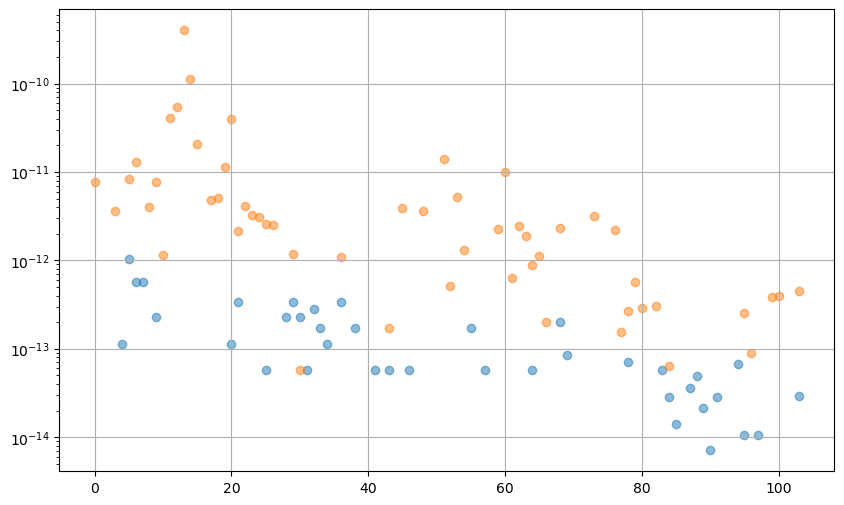

In [ ]:

plt.figure(figsize=(10,6))
plt.scatter(x=[i for i in range(104)],  y=s1-s0 ,alpha=0.5)
plt.scatter(x=[i for i in range(104)],  y=s2[:104]-s0 ,alpha=0.5) # PCA - перед SVD из столбцов вычитает среднее
#plt.scatter(x=[i for i in range(len(s ))],  y=s  ,alpha=0.5)
#plt.scatter(x=[i for i in range(104)],  y=s0 ,alpha=0.5)
plt.grid()
plt.yscale('log')
plt.show()


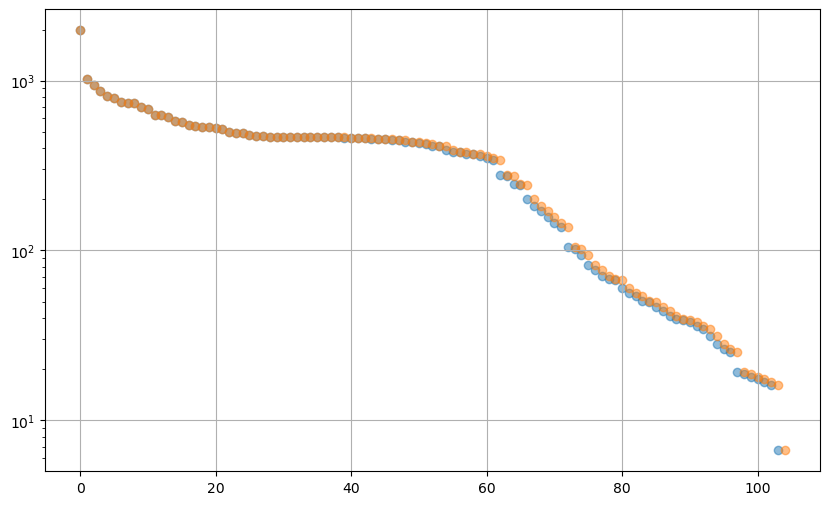

In [149]:

plt.figure(figsize=(10,6))
plt.scatter(x=[i for i in range(len(s1))],  y=s1 ,alpha=0.5)
plt.scatter(x=[i for i in range(len(s ))],  y=s  ,alpha=0.5)
plt.grid()
plt.yscale('log')
plt.show()

In [150]:
s1[0], s1[-1], s1[0]/s1[-1]

(1981.4288381184658, 6.653982324255483, 297.7808989506399)

In [151]:
s[0], s[-1], s[0]/s[-1]

(1981.428838118462, 6.653982324255591, 297.7808989506344)

## время обычного обучения

In [16]:
penalty_None_solvers = ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
all_solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']


In [67]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_tr, y_tr)
model.predict_proba(X_tst)

array([[0.92612889, 0.07387111],
       [0.93134401, 0.06865599],
       [0.98968017, 0.01031983],
       ...,
       [0.88908251, 0.11091749],
       [0.90997696, 0.09002304],
       [0.96302776, 0.03697224]])

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from time import time

print('penaly=None')
def fit(solver):
	model = LogisticRegression(solver=solver, penalty=None,tol=1e-8, max_iter=500)
	model.fit(X_tr, y_tr)
for solver in penalty_None_solvers:
	print(solver)
	t = time()
	fit(solver)
	print(solver,time()-t)

print('penaly=default')
def fit(solver):
	model = LogisticRegression(solver=solver, tol=1e-8, max_iter=500)
	model.fit(X_tr, y_tr)
for solver in all_solvers:
	print(solver)
	t = time()
	fit(solver)
	print(solver,time()-t)

penaly=None
lbfgs


c:\Users\FeelUs\miniforge3\envs\nout\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


lbfgs 54.52352285385132
newton-cg
newton-cg 129.09006547927856
newton-cholesky
newton-cholesky 65.4445698261261
sag


c:\Users\FeelUs\miniforge3\envs\nout\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


sag 212.76967859268188
saga


c:\Users\FeelUs\miniforge3\envs\nout\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


saga 248.32268261909485
penaly=default
lbfgs


c:\Users\FeelUs\miniforge3\envs\nout\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


lbfgs 53.69097399711609
liblinear
liblinear 163.14151692390442
newton-cg
newton-cg 81.19234657287598
newton-cholesky
newton-cholesky 55.436182260513306
sag


c:\Users\FeelUs\miniforge3\envs\nout\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


sag 213.8185715675354
saga
saga 273.87490725517273


c:\Users\FeelUs\miniforge3\envs\nout\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## вемя обучения на QR-разложении матрицы X

In [51]:
%timeit np.linalg.qr(np.hstack([np.ones((X_tr.shape[0],1)),X_tr]))

14 s ± 323 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from sklearn.linear_model import LogisticRegression
from time import time

X1  = np.hstack([np.ones((X_tr.shape[0],1)),X_tr])
Q,R = np.linalg.qr(X1)

def fit(solver):
	Q_model = LogisticRegression(solver=solver, fit_intercept=False,penalty=None,tol=1e-8, max_iter=500)
	return Q_model.fit(Q, y_tr)
for solver in penalty_None_solvers:
	print(solver)
	t = time()
	fit(solver)
	print(solver,time()-t)



lbfgs
lbfgs 2.7346506118774414
newton-cg
newton-cg 10.164584636688232
newton-cholesky
newton-cholesky 44.63070821762085
sag


c:\Users\FeelUs\miniforge3\envs\nout\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


sag 213.71479988098145
saga
saga 252.10789847373962


c:\Users\FeelUs\miniforge3\envs\nout\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## сравнение результатов времени и точности обучения

время QR-разложения = 14c  
время <0 означает, что метод не сошёлся за это время


|метод            | cond=298 , penalty=None | cond=298 , penalty=default | cond=1, penalty=None |
|-----------------|-------------------------|----------------------------|----------------------|
| lbfgs           | -54                     | -53                        | 2.7                  |
| liblinear       | --                      | 163                        | --                   |
| newton-cg       | 129                     | 81                         | 10.2                 |
| newton-cholesky | 65                      | 55                         | 44                   |
| sag             | -212                    | -213                       | -213                 |
| saga            | -248                    | -273                       | -252                 |



In [ ]:
%timeit np.linalg.qr(np.hstack([np.ones((X_tr.shape[0],1)),X_tr]))

14 s ± 323 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
Q_model = LogisticRegression(solver='lbfgs', fit_intercept=False,penalty=None,tol=1e-8, max_iter=500)
Q_model.fit(Q, y_tr)
w = (splin.solve_triangular(R, Q_model.coef_.T, lower=False)).T[0]
#w = (np.linalg.inv(R)@Q_model.coef_.T).T[0]

QX_model = LogisticRegression()
QX_model.coef_ = w[None,1:]
QX_model.intercept_ = w[0:1]
QX_model.classes_ = np.array([0, 1])
print('QR: roc_auc_score:',roc_auc_score(y_tst, QX_model.predict_proba(X_tst)[:, 1]))

X_model = LogisticRegression(solver='newton-cholesky', penalty=None,tol=1e-8, max_iter=500)
X_model.fit(X_tr, y_tr)
print('direct: roc_auc_score:',roc_auc_score(y_tst, X_model.predict_proba(X_tst)[:, 1]))


QR: roc_auc_score: 0.7380463059118151
direct: roc_auc_score: 0.7380456050174563


In [52]:
X_model = LogisticRegression(solver='newton-cholesky', tol=1e-8, max_iter=500)
X_model.fit(X_tr, y_tr)
print('direct with penalty: roc_auc_score:',roc_auc_score(y_tst, X_model.predict_proba(X_tst)[:, 1]))

direct with penalty: roc_auc_score: 0.7372069659743414


## сравнение QR и PCA

In [ ]:
pca_norm = PCA_norm(n_components=None)
Q = pca_norm.fit_transform(X_tr)
print('orthogonality:',np.linalg.norm(Q.T @ Q - np.eye(X_tr.shape[1]+1)))


orthogonality: 7.2265372051068134e-09


In [ ]:
from sklearn.pipeline import Pipeline

def fit():
	pca_model = Pipeline([
		('pca', PCA_norm(n_components=None)),
		('model', LogisticRegression(solver='lbfgs', fit_intercept=False,penalty=None,tol=1e-8)),
	])
	return pca_model.fit(X_tr, y_tr)

%timeit fit() # learning
pca_model = fit()
%timeit pca_model.predict_proba(X_tst) # inference
print('PCA: roc_auc_score:',roc_auc_score(y_tst, pca_model.predict_proba(X_tst)[:, 1]))


8.25 s ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.51 s ± 35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
PCA: roc_auc_score: 0.7380463059118151


In [140]:
def fit():
	qr_model = QR_regression(solver='lbfgs', tol=1e-8)
	return qr_model.fit(X_tr, y_tr)
%timeit fit() # learning
qr_model = fit()
%timeit qr_model.predict_proba(X_tst) # inference
print('QR: roc_auc_score:',roc_auc_score(y_tst, qr_model.predict_proba(X_tst)[:, 1]))

16.5 s ± 146 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
37.5 ms ± 446 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
QR: roc_auc_score: 0.7380463059118151


In [145]:
pca = PCA()
%timeit pca.fit(X_tr)
%timeit pca.fit_transform(X_tr)
X1 = np.hstack([np.ones((X_tr.shape[0],1)),X_tr])
%timeit np.linalg.svd(X_tr,full_matrices=False)
%timeit np.linalg.qr(X1)


2.25 s ± 80.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.19 s ± 8.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
17.8 s ± 291 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13.3 s ± 220 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [148]:
 %timeit PCA(svd_solver='full').fit(X_tr)
 %timeit PCA(svd_solver='covariance_eigh').fit(X_tr)
 # Предварительно вычислите ковариационную матрицу (по центрированным данным), 
 # запустите классическое разложение ковариационной матрицы по собственным значениям обычно с использованием LAPACK 
 # и выберите компоненты путем последующей обработки. 
 # Этот решатель очень эффективен для n_samples >> n_features и small n_features. 
 # Однако в противном случае он недоступен для больших n_features (большой объем памяти, необходимой для осуществления ковариационная матрица). 
 # Также обратите внимание, что по сравнению с “полным” решателем, этот решатель эффективно удваивает номер условия 
 # и, следовательно, является менее стабильным в числовом отношении (например, для входных данных с большим диапазоном особых значений). 
 %timeit PCA(svd_solver='arpack').fit(X_tr)
 %timeit PCA(svd_solver='randomized').fit(X_tr)
 


17.4 s ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.25 s ± 55.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
29.9 s ± 812 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 5s ± 1.29 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
X_tr.shape

(215290, 104)

In [6]:
 from sklearn.decomposition import PCA
 %timeit PCA(svd_solver='full').fit(np.random.normal(size=(200000,100)))

15.7 s ± 515 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit PCA(svd_solver='full').fit(np.random.normal(size=(20000,100)))
%timeit PCA(svd_solver='full').fit(np.random.normal(size=(2000,100)))

1.26 s ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
89.5 ms ± 3.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit PCA(svd_solver='full').fit(np.random.normal(size=(20000,10)))
%timeit PCA(svd_solver='full').fit(np.random.normal(size=(20000,100)))
%timeit PCA(svd_solver='full').fit(np.random.normal(size=(20000,1000)))


25.6 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.37 s ± 92.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 41s ± 2.71 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit PCA(svd_solver='covariance_eigh').fit(np.random.normal(size=(200000,100)))
%timeit PCA(svd_solver='covariance_eigh').fit(np.random.normal(size=(20000,100)))
%timeit PCA(svd_solver='covariance_eigh').fit(np.random.normal(size=(2000,100)))
%timeit PCA(svd_solver='covariance_eigh').fit(np.random.normal(size=(20000,10)))
%timeit PCA(svd_solver='covariance_eigh').fit(np.random.normal(size=(20000,100)))
%timeit PCA(svd_solver='covariance_eigh').fit(np.random.normal(size=(20000,1000)))

3.9 s ± 55.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
403 ms ± 75.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
30.8 ms ± 4.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12 ms ± 547 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
399 ms ± 67.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.4 s ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Стохастическое QR разложение

### по столбцам

In [31]:
Q,R = np.linalg.qr(np.hstack([np.ones((X_tr.shape[0],1)),X_tr]))

<Axes: >

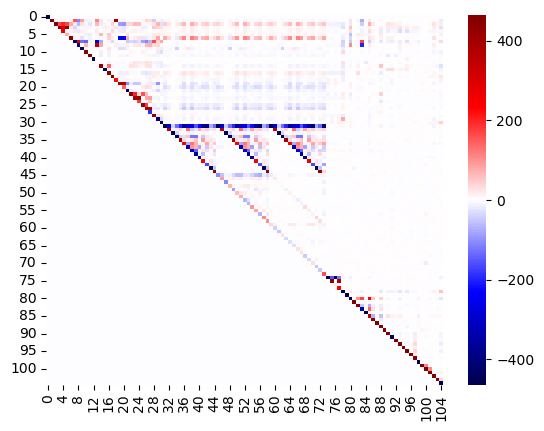

In [32]:
import seaborn as sns
sns.heatmap(R, center=0, cmap='seismic') 

<Axes: >

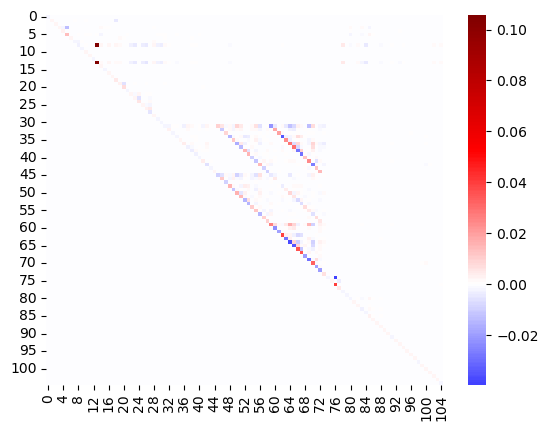

In [33]:
sns.heatmap(np.linalg.inv(R), center=0, cmap='seismic') 

In [42]:
ones_koef = np.sqrt(X_tr.shape[0])
ones_koef

463.99353443771173

In [36]:
d = np.zeros(X_tr.shape[1]+1)
S = np.zeros((X_tr.shape[1]+1,X_tr.shape[1]+1))

In [51]:
d[0]=1
S[0,1] = np.mean(X_tr[:,0])
Q_0 = X_tr[:,0]-S[0,1]
d[1] = 1/(np.linalg.norm(Q_0)/ones_koef)
Q0 = Q_0*d[1]
d[:3]

array([1., 1., 0.])

In [66]:
np.linalg.norm(Q0-Q[:,1]*ones_koef)

2.5491037910317697e-10

In [69]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(Q0[:,None], X_tr[:,1])
S[0,2] = reg.intercept_
S[1,2] = reg.coef_[0]
Q_1 = X_tr[:,1]-reg.predict(Q0[:,None])
d[2] = ones_koef/np.linalg.norm(Q_1)
Q1 = Q_1*d[2]
d[:4]



array([1.        , 1.        , 1.00030453, 0.        ])

In [70]:
np.linalg.norm(Q1-Q[:,2]*ones_koef)

4.566558950480828e-11

In [75]:
QQ = np.hstack([ Q0[:,None],Q1[:,None] ])
diff = np.zeros(X_tr.shape[1])
for i in range(2,X_tr.shape[1]):
	reg = LinearRegression().fit(QQ, X_tr[:,i])
	S[0,i+1] = reg.intercept_
	S[1:i+1,i+1] = reg.coef_
	Q_i = X_tr[:,i] - reg.predict(QQ)
	d[i+1] = ones_koef/np.linalg.norm(Q_i)
	QQ = np.hstack([QQ, Q_i[:,None]*d[i+1]])
	print(i,np.linalg.norm(QQ[:,i]-Q[:,i+1]*ones_koef))
	diff[i] = np.linalg.norm(QQ[:,i]-Q[:,i+1]*ones_koef)

2 8.744922847750532e-11
3 1.6295026212523165e-10
4 4.4069650093821054e-10
5 5.680336520719745e-11
6 927.9870688754205
7 927.9870688754239
8 927.9870688754223
9 8.83458577312508e-11
10 5.111146247167326e-11
11 927.987068875422
12 4.591883595993405e-09
13 8.350710694789518e-11
14 927.9870688754271
15 1.1855752085484235e-10
16 5.003293795573604e-11
17 3.960373596289029e-09
18 1.2322271283941922e-10
19 2.727130169062379e-10
20 927.9870688754222
21 9.86862009905167e-11
22 1.6583352726964608e-10
23 8.761864526289973e-11
24 1.6927378347419868e-10
25 3.3030358984453053e-10
26 927.9870688754163
27 2.056933022222292e-10
28 927.9870688754191
29 927.9870688754174
30 927.9870688754168
31 2.4464299510884265e-11
32 927.9870688754119
33 927.9870688754187
34 2.5105974653120703e-11
35 1.461487685193384e-10
36 927.987068875429
37 927.9870688754119
38 927.9870688754316
39 927.9870688754271
40 4.87726510840677e-11
41 927.9870688754222
42 927.9870688754118
43 2.536449125535501e-11
44 927.9870688754302
45 1.

In [81]:
((diff<0.0001) ^ (diff>10)).all()

True

In [109]:
Rsign = np.hstack([-1. , (diff<0.0001).astype(float) - (diff>10).astype(float)])
Rsign

array([-1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
        1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,
       -1., -1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,
       -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,
       -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
       -1.])

In [110]:
np.linalg.norm(np.hstack([np.ones((X_tr.shape[0],1)), QQ ]) - Rsign*Q*ones_koef)

6.5175650598032396e-09

In [121]:
np.linalg.norm(X_tr - (np.hstack([np.ones((X_tr.shape[0],1)), QQ ]) @ (np.eye(X_tr.shape[1]+1)/d + S))[:,1:] )

4.027097122229736e-13

In [122]:
np.linalg.norm(np.hstack([np.ones((X_tr.shape[0],1)),X_tr]) - Q@R)

1.6906280725415998e-09

### по строкам

In [4]:
import matplotlib.pyplot as plt

import scipy as sp
N = 3000
X0 = 1 + (np.random.randint(2,size=(N,1))*2-1)*0.1  # np.random.normal(size=(100,1))*0.1
X1 = np.hstack([np.ones((X0.shape[0],1)),X0])
X1 = np.hstack([X1, X1[:,0:1]+3*X1[:,1:2]+(np.random.randint(2,size=(N,1))*2-1)*0.01])
X1

array([[1.  , 0.9 , 3.71],
       [1.  , 1.1 , 4.29],
       [1.  , 1.1 , 4.31],
       ...,
       [1.  , 0.9 , 3.69],
       [1.  , 1.1 , 4.31],
       [1.  , 0.9 , 3.69]])

In [ ]:
N = X_tr.shape[0]
#perm = np.arange(N)
perm = np.random.permutation(N)
#X1 = np.hstack([np.ones((N,1)),X_tr[perm,:20]])
#X1[X1[:,12]<-10,12]=X1[0,12]
X1 = X_tr[perm,:30]
X1[X1[:,11]<-10,11]=X1[0,11]
N

215290

In [29]:
from tqdm import tqdm

S = np.zeros((X1.shape[1],X1.shape[1]))
sqd = X1[0,:]**2

Rhist = []
Qhist = []
QS1hist = []
QS2hist = []
dhist = []
Alhist = []
print('total:',X1.shape[0])
for i in tqdm(range(X1.shape[0])):
	#if i%100==0 : print(i)
	alpha = 0.01/(i+2)**0.3 # Learning rate
	beta = alpha

	Alhist.append(alpha)

	X = X1[i]
	R = np.eye(X1.shape[1])*np.sqrt(sqd)+S
	Rhist.append(R)

	Q = sp.linalg.solve_triangular(R.T, X, lower=True)
	Qhist.append(Q)
	QS1hist.append(Q@S)

	dS = - Q[:,None]*(X-Q@S)[None,:]
	np.fill_diagonal(dS,0)
	S -= alpha* np.triu(dS)
	QS2hist.append(Q@S)

	sqd = (1-beta)*sqd + beta*(X-Q@S)**2
	dhist.append(sqd)
R = np.eye(X1.shape[1])*np.sqrt(sqd)+S
R

total: 215290


100%|██████████| 215290/215290 [00:41<00:00, 5222.18it/s]


array([[ 9.85983586e-01,  3.48683190e-02,  1.52694271e-02,
         2.15799414e-02,  8.71721617e-04, -2.27718803e-02,
         3.41716494e-01, -2.47167273e-01,  1.82003685e-01,
        -3.71114961e-02,  2.99995617e-02,  5.05999733e-06,
         2.45001515e-01,  2.11597565e-02, -3.27749742e-03,
        -4.90729164e-02,  2.70892479e-02,  8.75329660e-01,
         1.90183861e-02,  2.46441500e-02,  3.84879130e-05,
        -1.66204884e-02,  5.52155414e-03,  7.92778083e-03,
         1.61774915e-02,  5.43270942e-02,  7.86441583e-02,
        -1.12462049e-01, -1.15854463e-02, -2.15245023e-02],
       [ 0.00000000e+00,  9.03000662e-01,  3.83317492e-01,
         4.58861569e-01,  3.71001309e-01,  2.00551969e-01,
         5.79102475e-02, -1.49195539e-01,  7.36655068e-02,
         2.32651427e-02, -5.51366076e-02, -6.25344379e-06,
         1.30391489e-01, -9.09402628e-02, -2.27566006e-03,
        -3.54085440e-03,  9.66473235e-02,  8.19066210e-03,
        -1.88990554e-01, -1.63817116e-01,  5.90148094e-

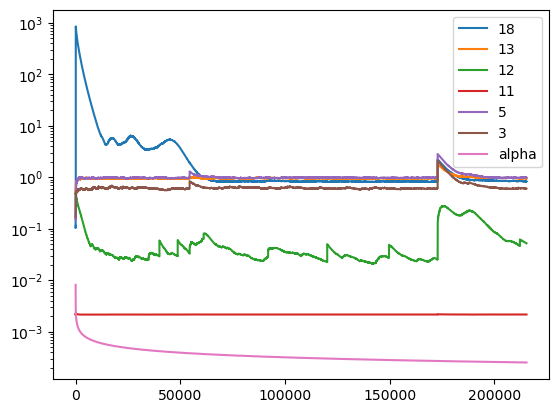

In [ ]:
#plt.plot([np.abs(X-Q@S)[2] for X,Q,S in zip(X1,Qhist,Shist)])

plt.plot([np.sqrt(sqd[18]) for sqd in dhist],label=18)
plt.plot([np.sqrt(sqd[13]) for sqd in dhist],label=13)
plt.plot([np.sqrt(sqd[12]) for sqd in dhist],label=12)
plt.plot([np.sqrt(sqd[11]) for sqd in dhist],label=11)
#plt.plot([np.sqrt(sqd[9]) for sqd in dhist],label=9)
#plt.plot([np.sqrt(sqd[7]) for sqd in dhist],label=7)
plt.plot([np.sqrt(sqd[5]) for sqd in dhist],label=5)
plt.plot([np.sqrt(sqd[3]) for sqd in dhist],label=3)
#plt.plot([np.sqrt(sqd[1]) for sqd in dhist],label=1)

plt.plot(Alhist,label='lr')

plt.yscale('log')
plt.legend()
	#print((X-Q@S))

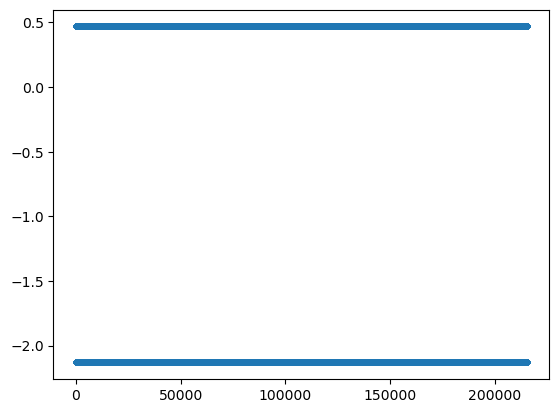

In [28]:
plt.plot(X1[:,12],'.')

1656.2271703371007


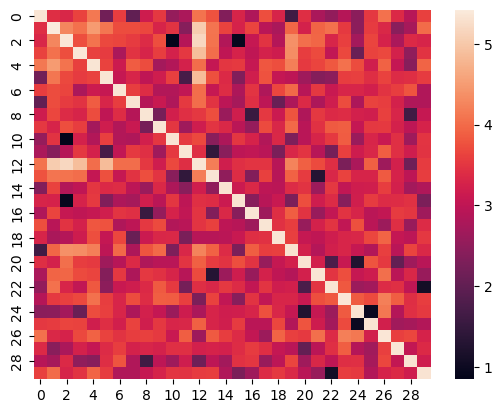

In [32]:
ones_koef = np.sqrt(X1.shape[0])

Q = sp.linalg.solve_triangular(R.T, X1.T, lower=True).T
QTQ = Q.T @ Q

import seaborn as sns
sns.heatmap(np.log10(np.abs(QTQ))) 
dnorm = np.linalg.norm(np.diag(QTQ))
np.fill_diagonal(QTQ,0)
print(dnorm*ones_koef/np.linalg.norm(QTQ))

In [33]:
u,s,v = np.linalg.svd(Q,full_matrices=False)
s[0]/s[-1]

5.144930293329119

In [34]:
u,s,v = np.linalg.svd(X1,full_matrices=False)
s[0]/s[-1]

902.8230837206459

4.5664261132609096e+16


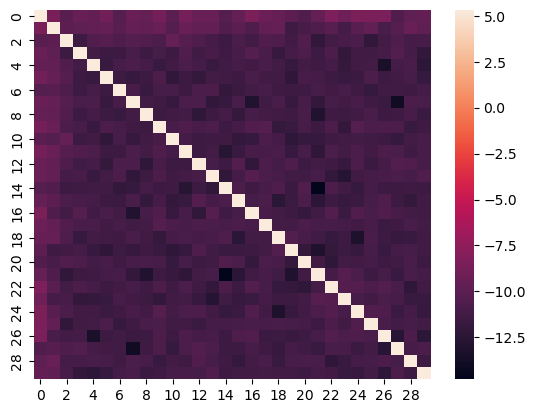

In [22]:
ones_koef = np.sqrt(X1.shape[0])
QQ,RR = np.linalg.qr(X1)
#Sign = np.diag([-1,-1,-1])
#Sign@
RR/=ones_koef
QQ*=ones_koef

QTQ = QQ.T @ QQ

import seaborn as sns
sns.heatmap(np.log10(np.abs(QTQ))) 
dnorm = np.linalg.norm(np.diag(QTQ))
np.fill_diagonal(QTQ,0)
print(dnorm*ones_koef/np.linalg.norm(QTQ))

### тесты по строкам

In [79]:
def test(X1, lr=0.01, p=0.3):
	S = np.zeros((X1.shape[1],X1.shape[1]))
	sqd = X1[0,:]**2

	Rhist = []
	Qhist = []
	QS1hist = []
	QS2hist = []
	dhist = []
	Alhist = []
	print('total:',X1.shape[0])
	for i in tqdm(range(X1.shape[0])):
		#if i%100==0 : print(i)
		alpha = lr/(i+2)**p # Learning rate
		beta = alpha

		#Alhist.append(alpha)

		X = X1[i]
		R = np.eye(X1.shape[1])*np.sqrt(sqd)+S
		#Rhist.append(R)

		Q = sp.linalg.solve_triangular(R.T, X, lower=True)
		#Qhist.append(Q)
		#QS1hist.append(Q@S)

		dS = - Q[:,None]*(X-Q@S)[None,:]
		np.fill_diagonal(dS,0)
		S -= alpha* np.triu(dS)
		#QS2hist.append(Q@S)

		sqd = (1-beta)*sqd + beta*(X-Q@S)**2
		dhist.append(sqd)
	R = np.eye(X1.shape[1])*np.sqrt(sqd)+S
	
	ones_koef = np.sqrt(X1.shape[0])

	Q = sp.linalg.solve_triangular(R.T, X1.T, lower=True).T
	QTQ = Q.T @ Q

	import seaborn as sns
	sns.heatmap(np.log10(np.abs(QTQ))) 
	#dnorm = np.linalg.norm(np.diag(QTQ))
	#np.fill_diagonal(QTQ,0)
	#print('диагональность:',dnorm*ones_koef/np.linalg.norm(QTQ))

	u,s,v = np.linalg.svd(Q,full_matrices=False)
	print('обусловленность:',s[0]/s[-1])

	u,s,v = np.linalg.svd(X1,full_matrices=False)
	print('обусловленность исходной:',s[0]/s[-1])

	return R, dhist
	

total: 215290


100%|██████████| 215290/215290 [00:33<00:00, 6463.38it/s]


диагональность: 4308.417177622107
обусловленность: 1.223071597459331
обусловленность исходной: 14.87400661379151


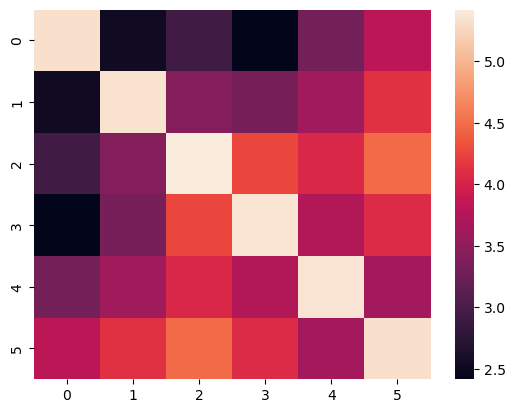

In [36]:
N = X_tr.shape[0]
perm = np.arange(N)
X1 = np.hstack([np.ones((N,1)),X_tr[perm,:5]])
R,dhist = test(X1)

total: 215290


100%|██████████| 215290/215290 [00:34<00:00, 6232.26it/s]


диагональность: 4989.359525977392
обусловленность: 1.237402719388089
обусловленность исходной: 15.009956909939461


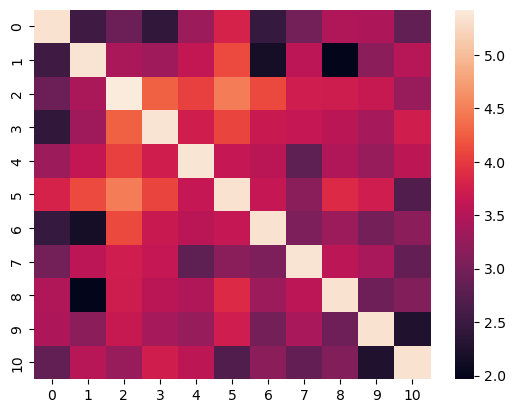

In [37]:
N = X_tr.shape[0]
perm = np.arange(N)
X1 = np.hstack([np.ones((N,1)),X_tr[perm,:10]])
R,dhist = test(X1)

total: 215290


100%|██████████| 215290/215290 [00:34<00:00, 6332.05it/s]


диагональность: 485.244937011579
обусловленность: 9.79791151148866e+18
обусловленность исходной: 122.56291172944348


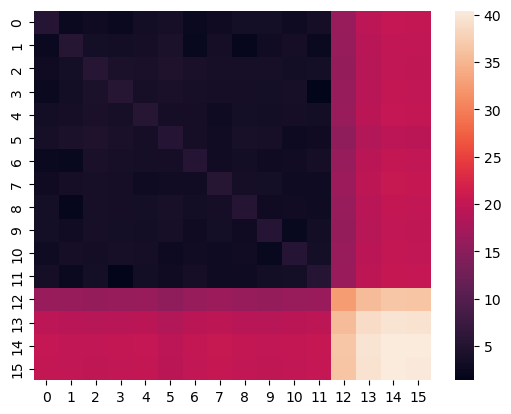

In [38]:
N = X_tr.shape[0]
perm = np.arange(N)
X1 = np.hstack([np.ones((N,1)),X_tr[perm,:15]])
R,dhist = test(X1)

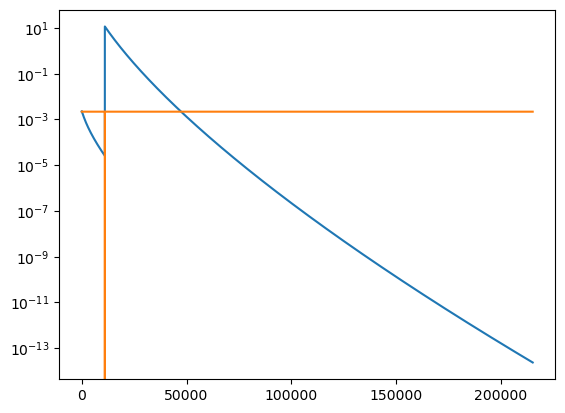

In [43]:
plt.plot([np.sqrt(sqd[12]) for sqd in dhist],label=12)
plt.plot(X1[:,12])
plt.yscale('log')

total: 215290


  0%|          | 0/215290 [00:00<?, ?it/s]

100%|██████████| 215290/215290 [00:30<00:00, 7068.52it/s]


обусловленность: 220113761776750.38
обусловленность исходной: 231040039838569.38


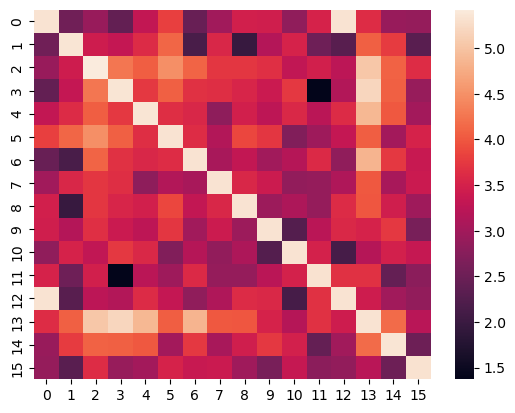

In [47]:
N = X_tr.shape[0]
perm = np.arange(N)
X1 = np.hstack([np.ones((N,1)),X_tr[perm,:15]])
X1[X1[:,12]<-10,12]=X1[0,12] # устраняем выброс
R,dhist = test(X1)



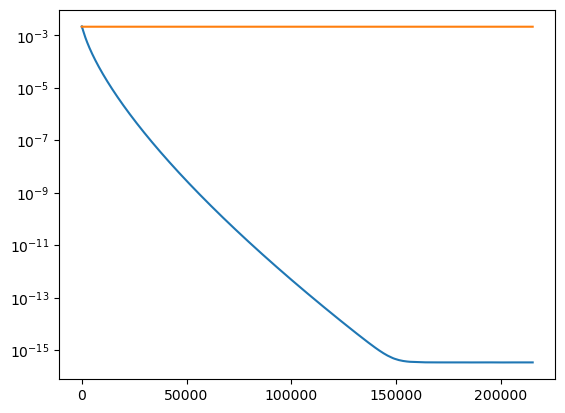

In [48]:
plt.plot([np.sqrt(sqd[12]) for sqd in dhist],label=12)
plt.plot(X1[:,12])
plt.yscale('log')

total: 215290


100%|██████████| 215290/215290 [00:28<00:00, 7543.20it/s]


обусловленность: 6797242.955997468
обусловленность исходной: 122.56291172945275


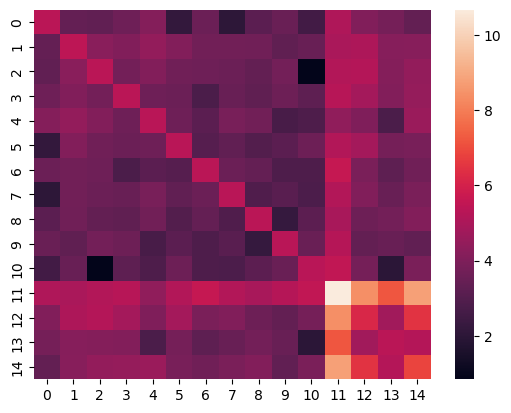

In [ ]:
N = X_tr.shape[0]
perm = np.arange(N)
X1 = X_tr[perm,:15]
X1[X1[:,12]<-10,12]=X1[0,12] # устраняем выброс, но не тот
R,dhist = test(X1)


total: 215290


100%|██████████| 215290/215290 [00:28<00:00, 7634.49it/s]


обусловленность: 5.025506935822356
обусловленность исходной: 821.4821461174905


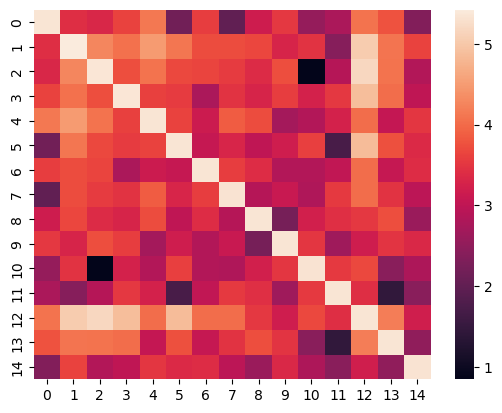

In [50]:
N = X_tr.shape[0]
perm = np.arange(N)
X1 = X_tr[perm,:15]
X1[X1[:,11]<-10,11]=X1[0,11] # устраняем выброс
R,dhist = test(X1)


total: 215290


100%|██████████| 215290/215290 [00:31<00:00, 6781.25it/s]


обусловленность: 5.144930293329119
обусловленность исходной: 902.8230837206459


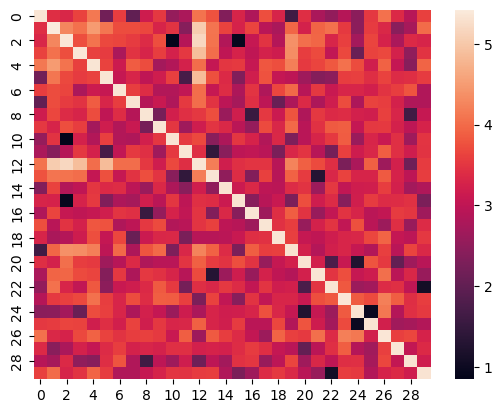

In [57]:
N = X_tr.shape[0]
perm = np.arange(N)
X1 = X_tr[perm,:30]
X1[X1[:,11]<-10,11]=X1[0,11] # устраняем выброс
R,dhist = test(X1)


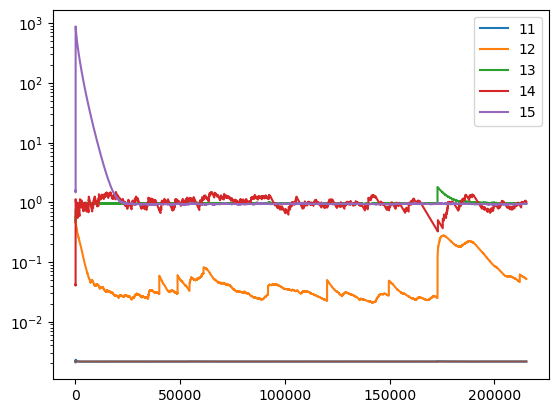

In [58]:
plt.plot([np.sqrt(sqd[11]) for sqd in dhist],label=11)
plt.plot([np.sqrt(sqd[12]) for sqd in dhist],label=12)
plt.plot([np.sqrt(sqd[13]) for sqd in dhist],label=13)
plt.plot([np.sqrt(sqd[14]) for sqd in dhist],label=14)
plt.plot([np.sqrt(sqd[15]) for sqd in dhist],label=15)
plt.plot(X1[:,11])
plt.yscale('log')
plt.legend()

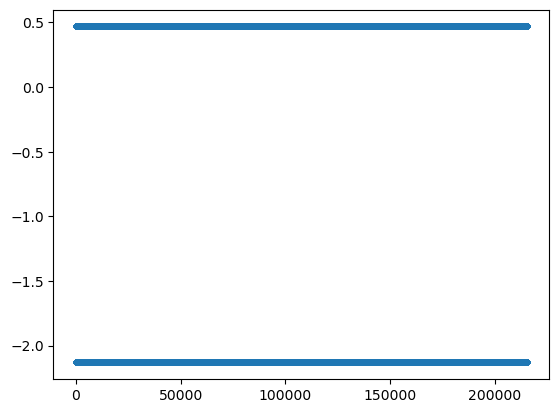

In [62]:
plt.plot(X1[:,12],'.')

total: 215290


100%|██████████| 215290/215290 [00:31<00:00, 6930.41it/s]


обусловленность: 7941547278.582878
обусловленность исходной: 135.29823462597201


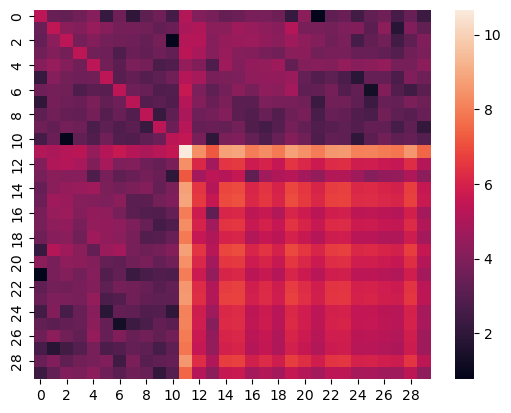

In [52]:
N = X_tr.shape[0]
perm = np.arange(N)
X1 = X_tr[perm,:30]
R,dhist = test(X1)


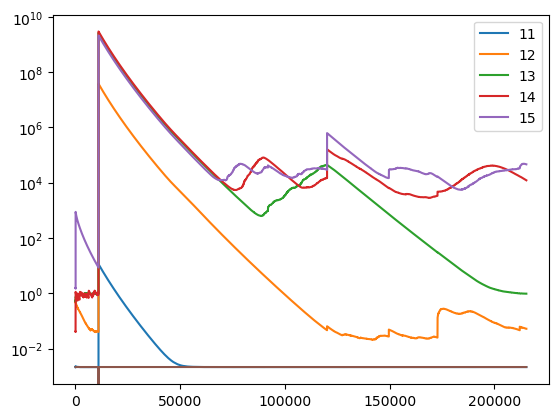

In [56]:
plt.plot([np.sqrt(sqd[11]) for sqd in dhist],label=11)
plt.plot([np.sqrt(sqd[12]) for sqd in dhist],label=12)
plt.plot([np.sqrt(sqd[13]) for sqd in dhist],label=13)
plt.plot([np.sqrt(sqd[14]) for sqd in dhist],label=14)
plt.plot([np.sqrt(sqd[15]) for sqd in dhist],label=15)
plt.plot(X1[:,11])
plt.yscale('log')
plt.legend()

total: 215290


100%|██████████| 215290/215290 [00:35<00:00, 6072.62it/s]


обусловленность: 5.1935800408604935
обусловленность исходной: 135.2981988347103


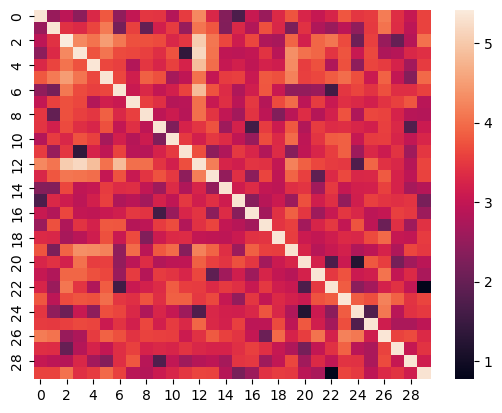

In [65]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(30) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test(X1)

total: 215290


100%|██████████| 215290/215290 [00:34<00:00, 6181.48it/s]


обусловленность: 42.21037511761783
обусловленность исходной: 150.22010332799545


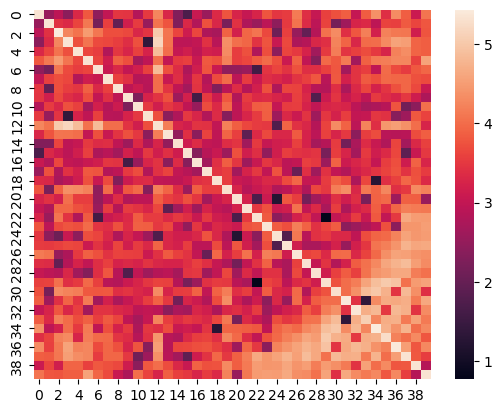

In [67]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(40) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test(X1)

total: 215290


100%|██████████| 215290/215290 [01:44<00:00, 2060.22it/s]


обусловленность: 852.5307277359416
обусловленность исходной: 288.5286925215387


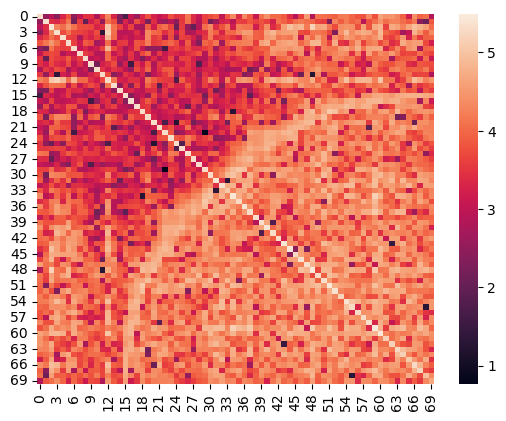

In [ ]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(70) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test(X1)

total: 215290


100%|██████████| 215290/215290 [01:58<00:00, 1819.98it/s]


обусловленность: 18.86422934012646
обусловленность исходной: 288.5286925215387


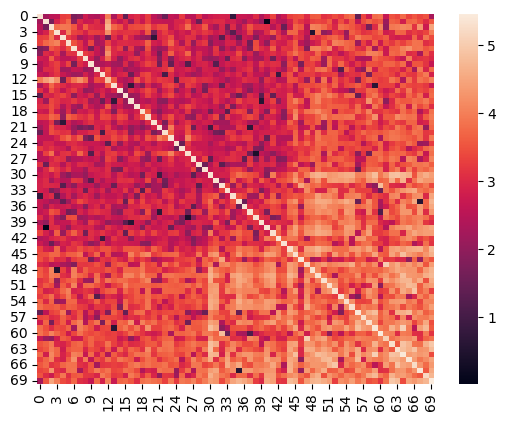

In [75]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(70) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test(X1,0.001)

total: 215290


100%|██████████| 215290/215290 [03:36<00:00, 993.80it/s] 


обусловленность: 7402113624848.262
обусловленность исходной: 297.7808433187816


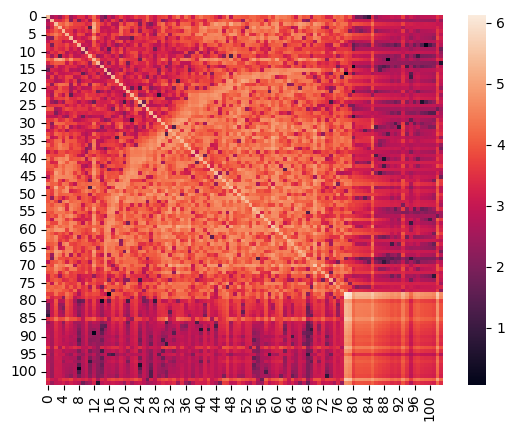

In [70]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test(X1)

total: 215290


100%|██████████| 215290/215290 [04:24<00:00, 814.73it/s]


обусловленность: 398.6569691962098
обусловленность исходной: 297.7808433187816


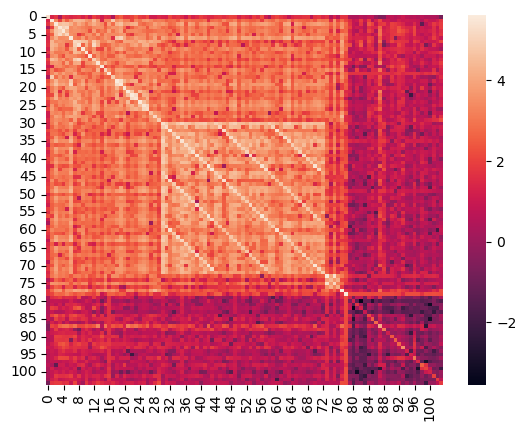

In [76]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test(X1,0.0001)

total: 215290


100%|██████████| 215290/215290 [04:14<00:00, 846.06it/s]


обусловленность: 233.60562985267842
обусловленность исходной: 297.7808433187816


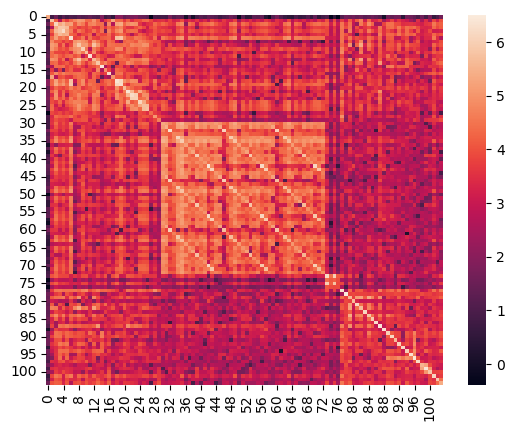

In [ ]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test(X1,0.00001)

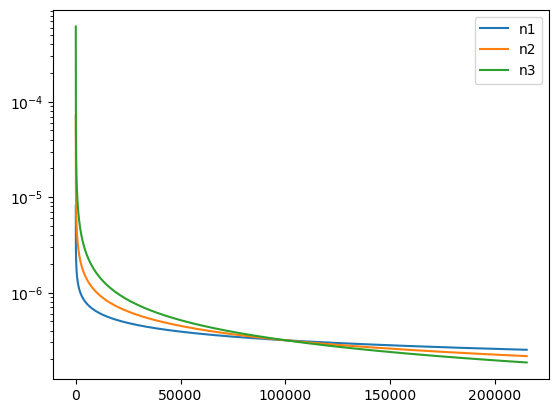

In [83]:
plt.plot([0.00001/(i+2)**0.3 for i in range(X1.shape[0]) ], label='n1')
plt.plot([0.0001/(i+2)**0.5 for i in range(X1.shape[0]) ], label='n2')
plt.plot([0.001/(i+2)**0.7 for i in range(X1.shape[0]) ], label='n3')

plt.yscale('log')
plt.legend()

total: 215290


100%|██████████| 215290/215290 [04:15<00:00, 842.52it/s]


обусловленность: 198.3908063211574
обусловленность исходной: 297.7808433187816


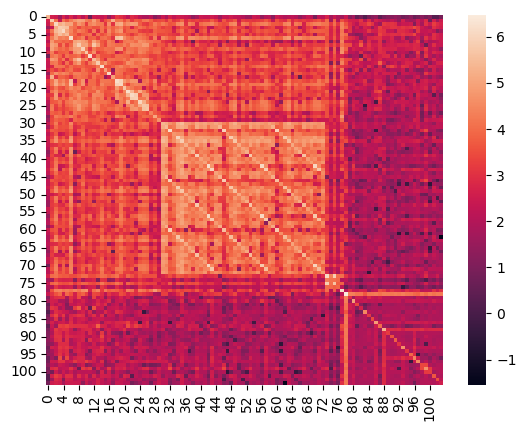

In [84]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test(X1,0.001,0.7)

total: 215290


100%|██████████| 215290/215290 [04:24<00:00, 814.53it/s]


обусловленность: 695.2673212162514
обусловленность исходной: 297.7808433187816


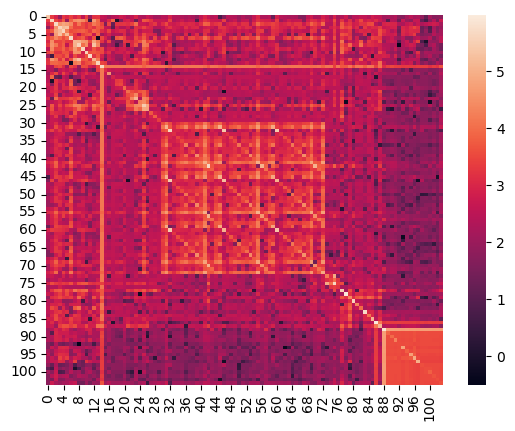

In [86]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test(X1,0.01,0.8)

total: 215290


100%|██████████| 215290/215290 [04:28<00:00, 802.47it/s]


обусловленность: 639.6301067455489
обусловленность исходной: 297.7808433187816


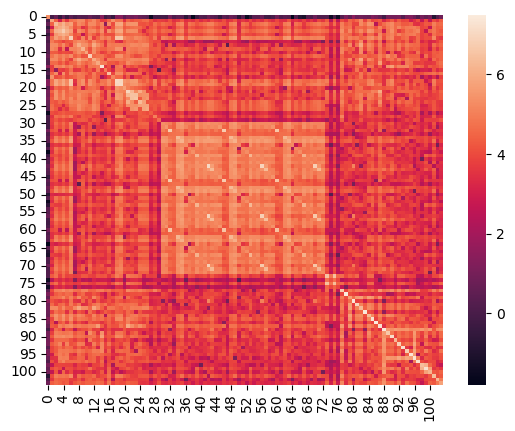

In [ ]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test(X1,0.000001)

<Axes: >

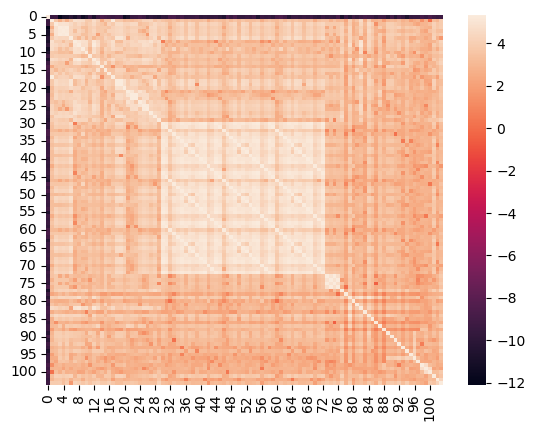

In [85]:
	QTQ = X1.T @ X1
	import seaborn as sns
	sns.heatmap(np.log10(np.abs(QTQ))) 

In [11]:
from tqdm import tqdm
import scipy as sp
def test2(X1):
	S = np.zeros((X1.shape[1],X1.shape[1]))
	sqd = X1[0,:]**2

	Rhist = []
	Qhist = []
	QS1hist = []
	QS2hist = []
	dhist = []
	Alhist = []
	print('total:',X1.shape[0])
	for i in tqdm(range(X1.shape[0])):
		#if i%100==0 : print(i)
		alpha = 0.01/(i+2)**0.3 # Learning rate
		beta = alpha

		#Alhist.append(alpha)

		X = X1[i]
		R = np.eye(X1.shape[1])*np.sqrt(sqd)+S
		#Rhist.append(R)

		Q = sp.linalg.solve_triangular(R.T, X, lower=True)
		#Qhist.append(Q)
		#QS1hist.append(Q@S)

		dS = - Q[:,None]*(X-Q@S)[None,:]
		np.fill_diagonal(dS,0)
		S -= alpha* dS                                  # убрал triu()
		#QS2hist.append(Q@S)

		sqd = (1-beta)*sqd + beta*(X-Q@S)**2
		dhist.append(sqd)
	R = np.eye(X1.shape[1])*np.sqrt(sqd)+S
	
	ones_koef = np.sqrt(X1.shape[0])

	Q = sp.linalg.solve_triangular(R.T, X1.T, lower=True).T
	QTQ = Q.T @ Q

	import seaborn as sns
	sns.heatmap(np.log10(np.abs(QTQ))) 
	#dnorm = np.linalg.norm(np.diag(QTQ))
	#np.fill_diagonal(QTQ,0)
	#print('диагональность:',dnorm*ones_koef/np.linalg.norm(QTQ))

	u,s,v = np.linalg.svd(Q,full_matrices=False)
	print('обусловленность:',s[0]/s[-1])

	u,s,v = np.linalg.svd(X1,full_matrices=False)
	print('обусловленность исходной:',s[0]/s[-1])

	return R, dhist
	

total: 215290


  0%|          | 0/215290 [00:00<?, ?it/s]

100%|██████████| 215290/215290 [00:26<00:00, 8006.43it/s]


обусловленность: 20.699026473067466
обусловленность исходной: 135.2981988347103


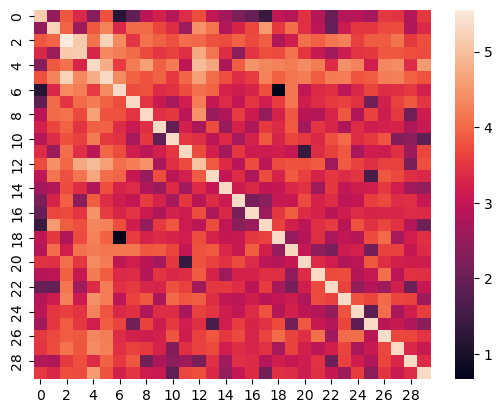

In [12]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(30) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test2(X1)

total: 215290


100%|██████████| 215290/215290 [00:35<00:00, 6072.62it/s]


обусловленность: 5.1935800408604935
обусловленность исходной: 135.2981988347103


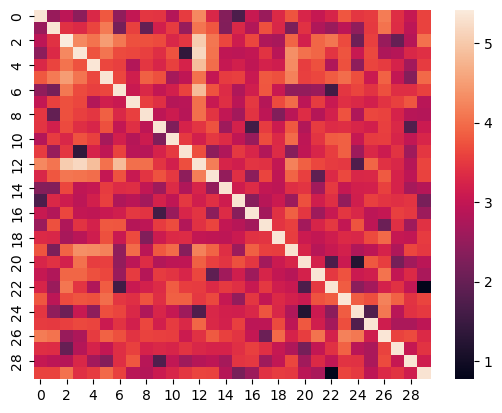

In [ ]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(30) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test(X1)

## кусочно-стохастическое QR разложение

In [74]:
def test3(X1, lr=0.01, p=0.3, n=3):
	d = int(X1.shape[1] *n)
	Q,RR = np.linalg.qr(X1[:d,:])
	sign = (np.diag(RR)>0).astype(float)*2-1
	RR = (sign*RR.T).T

	for i in tqdm(range(d, X1.shape[0]-d,d)):
		alpha = lr/(i+2)**p # Learning rate

		Q,R = np.linalg.qr(X1[i:i+d,:])
		sign = (np.diag(R)>0).astype(float)*2-1
		R = (sign*R.T).T

		RR = (1-alpha)*RR + alpha*R
	R = RR
	
	ones_koef = np.sqrt(X1.shape[0])

	Q = sp.linalg.solve_triangular(R.T, X1.T, lower=True).T
	QTQ = Q.T @ Q

	import seaborn as sns
	sns.heatmap(np.log10(np.abs(QTQ))) 
	#dnorm = np.linalg.norm(np.diag(QTQ))
	#np.fill_diagonal(QTQ,0)
	#print('диагональность:',dnorm*ones_koef/np.linalg.norm(QTQ))

	u,s,v = np.linalg.svd(Q,full_matrices=False)
	print('обусловленность:',s[0]/s[-1])

	u,s,v = np.linalg.svd(X1,full_matrices=False)
	print('обусловленность исходной:',s[0]/s[-1])

	return R, dhist
	

100%|██████████| 2391/2391 [00:00<00:00, 2719.64it/s]


обусловленность: 7.204718194418626
обусловленность исходной: 135.2981988347103


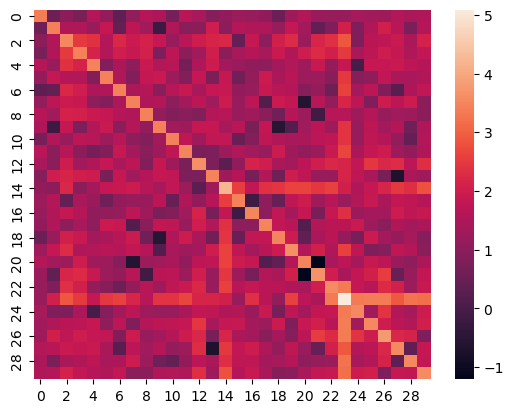

In [36]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(30) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test3(X1,1)

100%|██████████| 2391/2391 [00:00<00:00, 2706.19it/s]


обусловленность: 4.5856820797447995
обусловленность исходной: 135.2981988347103


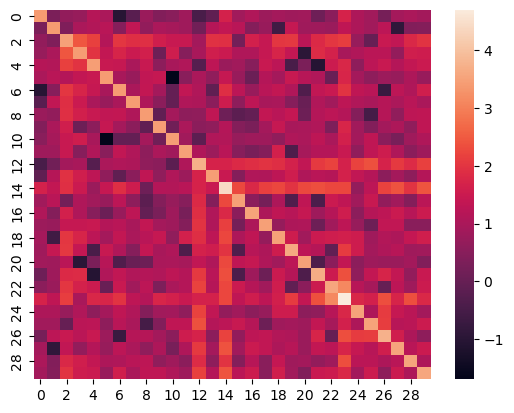

In [ ]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(30) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test3(X1,0.1)

100%|██████████| 2391/2391 [00:00<00:00, 2830.31it/s]


обусловленность: 11.054878320457078
обусловленность исходной: 135.2981988347103


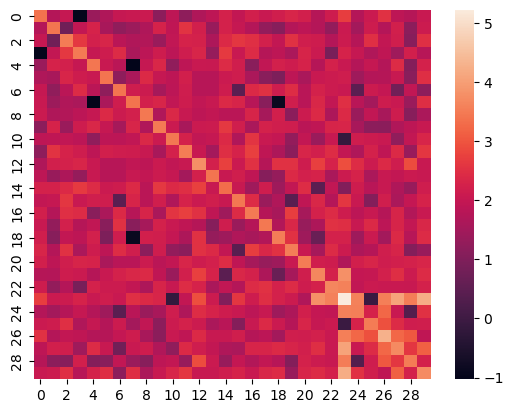

In [ ]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(30) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test3(X1,0.01)

100%|██████████| 2391/2391 [00:01<00:00, 2230.09it/s]


обусловленность: 155.5083987704058
обусловленность исходной: 135.2981988347103


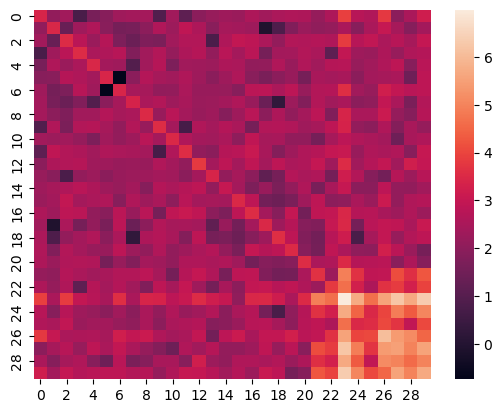

In [ ]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(30) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test3(X1,0.001)

100%|██████████| 1195/1195 [00:02<00:00, 565.95it/s]


обусловленность: 16.63520026201206
обусловленность исходной: 250.93310409132116


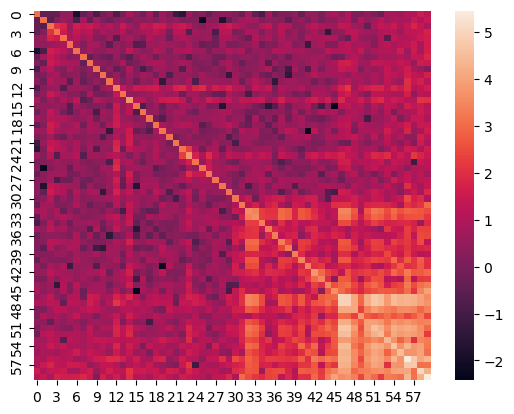

In [37]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(60) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test3(X1,0.1)

100%|██████████| 1195/1195 [00:02<00:00, 576.97it/s]


обусловленность: 19.62817928249543
обусловленность исходной: 250.93310409132116


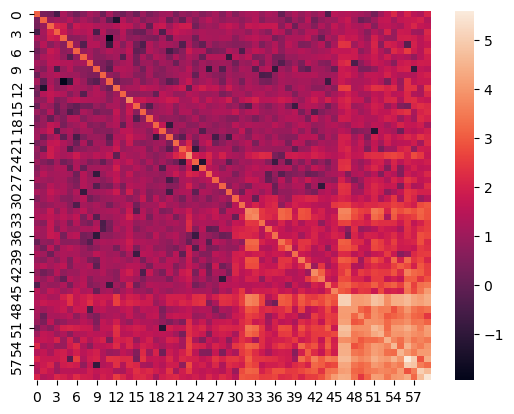

In [39]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(60) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test3(X1,1)

100%|██████████| 689/689 [00:05<00:00, 122.80it/s]


обусловленность: 103.68433382331156
обусловленность исходной: 297.7808433187816


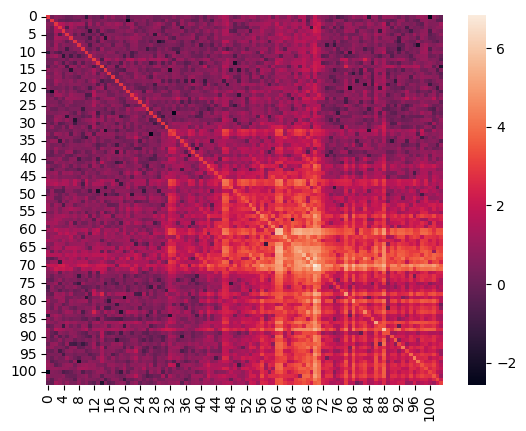

In [40]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test3(X1,0.1)

100%|██████████| 689/689 [00:05<00:00, 123.98it/s]


обусловленность: 3896.7343329463597
обусловленность исходной: 297.7808433187816


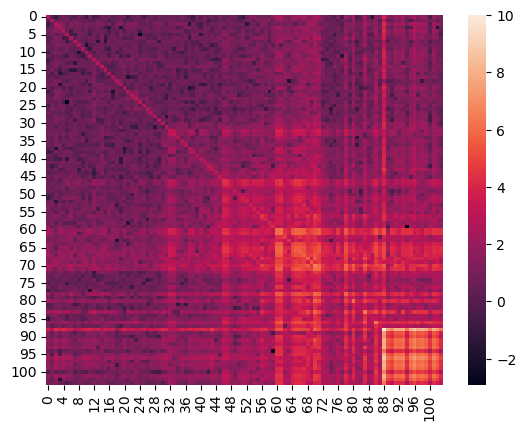

In [41]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test3(X1,1)

100%|██████████| 68/68 [00:06<00:00, 10.96it/s]


обусловленность: 45.377854697757904
обусловленность исходной: 297.7808433187816


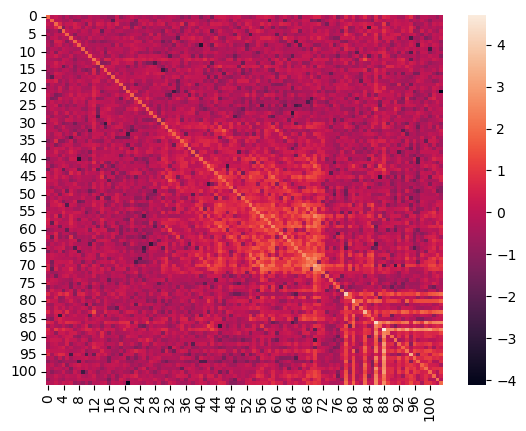

In [75]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test3(X1,0.1,0.3,30)

100%|██████████| 68/68 [00:06<00:00, 10.51it/s]


обусловленность: 8.219119974087214
обусловленность исходной: 297.7808433187816


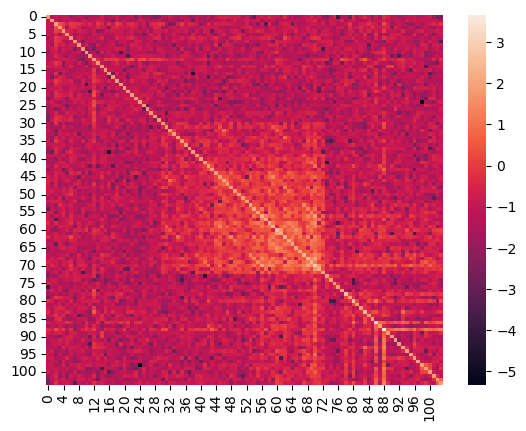

In [76]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test3(X1,1,0.3,30)

100%|██████████| 68/68 [00:06<00:00, 10.74it/s]


обусловленность: 3373.147921716285
обусловленность исходной: 297.7808433187816


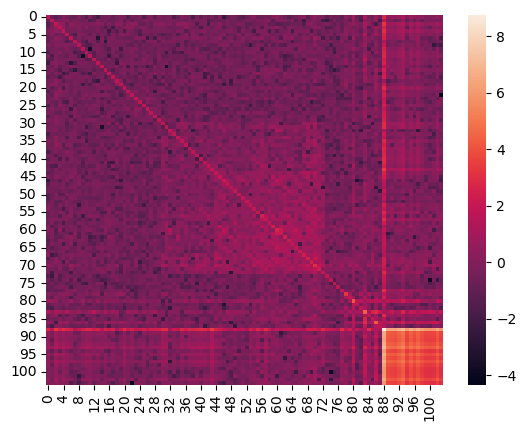

In [77]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])
R,dhist = test3(X1,10,0.3,30)

## обновление по строкам

In [5]:
import numba

@numba.jit
def compute_reflector(x,y):
	u=x
	v=y
	if v == 0:
		c = 1 
		s = 0
	else:
		mu = max(abs(u), abs(v))
		t = mu * np.sqrt((u*u/mu/mu) + (v*v/mu/mu))
		# t = sqrt(u*u + v*v)
		if u < 0 :
			t = -t
		c = u/t
		s = v/t
		x = t
		y = 0
	return c,s,x,y

@numba.jit
def apply_reflector(c,s,start,stop,X,Y):
	nu = s/(1+c)
	U = X[start:stop].copy()
	X[start:stop] = U*c + Y[start:stop]*s
	Y[start:stop] = (X[start:stop] + U)*nu - Y[start:stop]

@numba.jit
def apply_reflector_scalar(c,s,X,Y):
	nu = s/(1+c)
	U = X
	X = U*c + Y*s
	Y = (X + U)*nu - Y
	return X,Y

@numba.jit
def update_R(R,u):
	q = np.zeros(u.shape)
	v = 1.
	n = len(u)
	for l in range(n):
		c,s,R[l,l],u[l] = compute_reflector(R[l,l],u[l])
		apply_reflector(c,s, l+1,n, R[l,:],u)
		q[l],v = apply_reflector_scalar(c,s,q[l],v)


In [65]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])


u,s,v = np.linalg.svd(X1,full_matrices=False)
print('обусловленность исходной:',s[0]/s[-1])

обусловленность исходной: 297.7808433187816


In [66]:
d = X1.shape[1]
Q,R = np.linalg.qr(X1[:d,:])
sign = (np.diag(R)>0).astype(float)*2-1
R = (sign*R.T).T

X1c = X1.copy()

for i in tqdm(range(d,X1.shape[0])):
	update_R(R,X1c[i])

100%|██████████| 215186/215186 [00:28<00:00, 7573.87it/s]


обусловленность: 1.0000000000376412


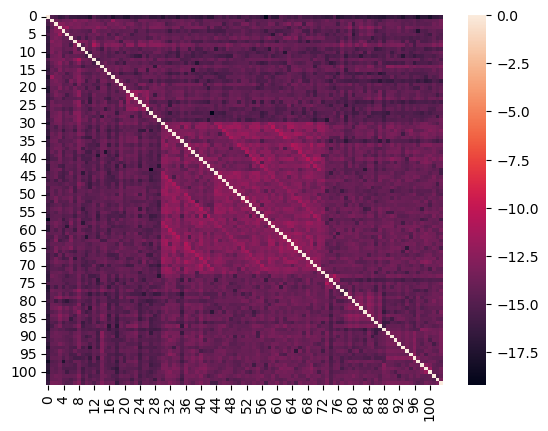

In [67]:
Q = sp.linalg.solve_triangular(R.T, X1.T, lower=True).T
QTQ = Q.T @ Q

import seaborn as sns
sns.heatmap(np.log10(np.abs(QTQ))) 
#dnorm = np.linalg.norm(np.diag(QTQ))
#np.fill_diagonal(QTQ,0)
#print('диагональность:',dnorm*ones_koef/np.linalg.norm(QTQ))

u,s,v = np.linalg.svd(Q,full_matrices=False)
print('обусловленность:',s[0]/s[-1])


<Axes: >

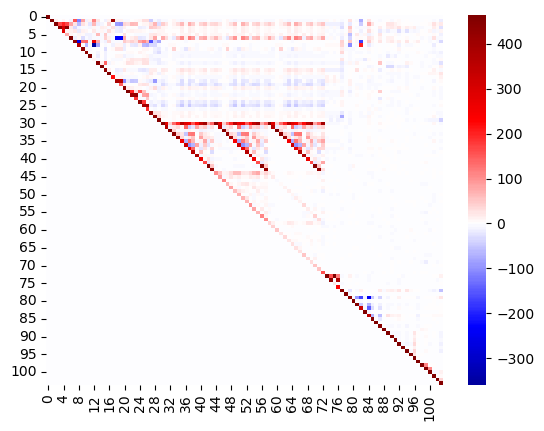

In [72]:
import seaborn as sns
sns.heatmap(R,center=0, cmap='seismic') 

<Axes: >

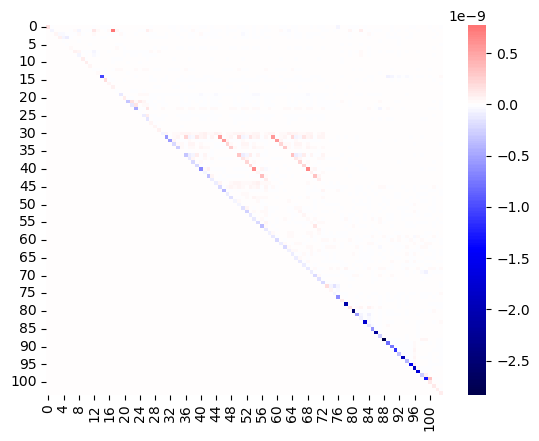

In [69]:
QQ,RR = np.linalg.qr(X1)
sign = (np.diag(RR)>0).astype(float)*2-1
RR = (sign*RR.T).T
sns.heatmap(R-RR,center=0, cmap='seismic') 

In [73]:
u,s,v = np.linalg.svd(QQ,full_matrices=False)
print('обусловленность:',s[0]/s[-1])


обусловленность: 1.0000000000000138


In [ ]:
# 1.0000000000376412
# 1.0000000000000138

In [4]:
N = X_tr.shape[0]
perm = np.arange(N)
cols = [i for i in range(X_tr.shape[1]) if i!=11]
X1 = np.hstack([np.ones((N,1)),X_tr[:,cols]])


u,s,v = np.linalg.svd(X1,full_matrices=False)
print('обусловленность исходной:',s[0]/s[-1])

обусловленность исходной: 297.7808433187816


In [7]:
from tqdm import tqdm

d = X1.shape[1]
R = np.eye(d)

X1c = X1.copy()

for i in tqdm(range(d,X1.shape[0])):
	update_R(R,X1c[i])

100%|██████████| 215186/215186 [00:33<00:00, 6386.72it/s]


обусловленность: 1.0139012946617278


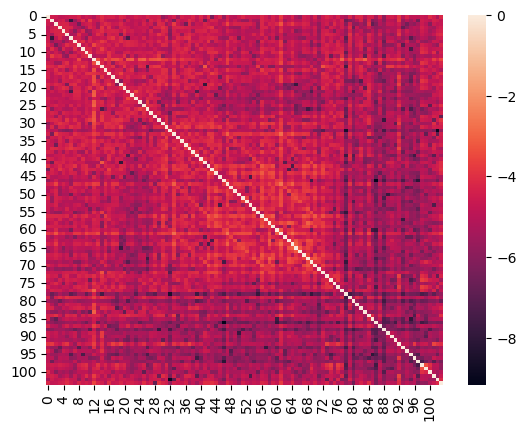

In [9]:
import scipy as sp

Q = sp.linalg.solve_triangular(R.T, X1.T, lower=True).T
QTQ = Q.T @ Q

import seaborn as sns
sns.heatmap(np.log10(np.abs(QTQ))) 
#dnorm = np.linalg.norm(np.diag(QTQ))
#np.fill_diagonal(QTQ,0)
#print('диагональность:',dnorm*ones_koef/np.linalg.norm(QTQ))

u,s,v = np.linalg.svd(Q,full_matrices=False)
print('обусловленность:',s[0]/s[-1])


<Axes: >

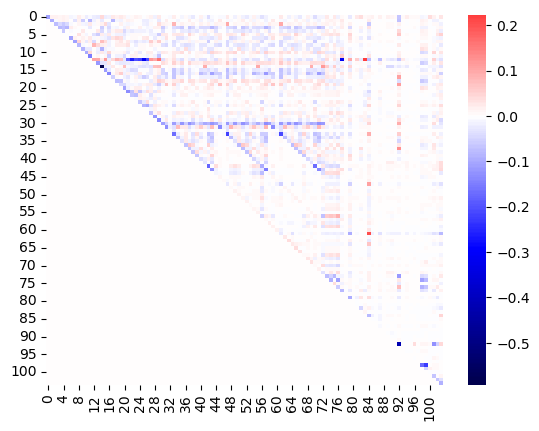

In [10]:
import seaborn as sns
QQ,RR = np.linalg.qr(X1)
sign = (np.diag(RR)>0).astype(float)*2-1
RR = (sign*RR.T).T
sns.heatmap(R-RR,center=0, cmap='seismic') 

## torch, SGD

In [4]:
import torch
from torch import nn
#from torch.optim import Optimizer
import torch.optim as optim
from collections import defaultdict

In [81]:
device = torch.device("cuda:0")

Xc_tr = torch.tensor(X_tr, device=device, requires_grad=False, dtype=torch.float32)
yc_tr = torch.tensor(y_tr/2+0.5, device=device, requires_grad=False, dtype=torch.long)

Xc_tst = torch.tensor(X_tst, device=device, requires_grad=False, dtype=torch.float32)
yc_tst = torch.tensor(y_tst/2+0.5, device=device, requires_grad=False, dtype=torch.long)


In [50]:
class LogRegModel(nn.Module):
	def __init__(self, input_size, bias=True):
		"""
		Initialization of Linear Model
		:param input_size: int, dimension of input vector
		"""
		super(LogRegModel, self).__init__()
		self.layer = nn.Linear(input_size, 1, bias).to(device)

	def forward(self, x):
		p = torch.sigmoid(self.layer(x))
		return torch.hstack([p,1-p])


def init_model(n, bias=True):
	"""
	:param n: int, input size for Linear Model
	:return: Linear Model with input size n
	"""
	torch.manual_seed(0)
	return LogRegModel(n, bias)

def get_batch_indexes(n, batch_size):
	"""
	:param batch_size: int, batch size
	:param n: int, the size of full dataset
	:return: list of batches
	"""
	indexes = np.arange(n)
	#indexes = np.random.permutation(indexes)
	batches = np.array_split(indexes, n//batch_size)
	return batches


loss = nn.CrossEntropyLoss()


In [15]:
from time import time
from tqdm import tqdm

logs = {} # defaultdict(lambda : ([],[],[])) # time, train_loss, test_loss

for LR in [0.001, 0.003, 0.01, 0.03, 0.1]:
	print('LR:',LR)
	model = init_model(X_tr.shape[1])
	optimizer = optim.SGD(model.parameters(),
							lr=LR,
							#momentum=args.momentum,
							#weight_decay=1/C
							)

	with torch.torch.no_grad():
		train_loss = loss(model(Xc_tr), yc_tr).cpu().item()
		test_loss  = loss(model(Xc_tst), yc_tst).cpu().item()
	t0 = time()
	logs[LR] = ([time()-t0], [train_loss], [test_loss])
	print(len(logs[LR][0])-1,logs[LR][0][-1],logs[LR][1][-1],logs[LR][2][-1])

	timer = 100
	test_time = 0
	#with tqdm(total=timer, desc="Progress", unit="s") as pbar:
	while time() - t0 - test_time < timer:
		for batch in get_batch_indexes(X_tr.shape[0], 32):
			loss_value = loss(model(Xc_tr[batch]), yc_tr[batch])
			loss_value.backward()
			optimizer.step()
			optimizer.zero_grad()
		t1 = time()
		with torch.torch.no_grad():
			logs[LR][0].append(t1-t0-test_time)
			logs[LR][1].append(loss(model(Xc_tr), yc_tr).cpu().item())
			logs[LR][2].append(loss(model(Xc_tst), yc_tst).cpu().item())
			print(len(logs[LR][0])-1,logs[LR][0][-1],logs[LR][1][-1],logs[LR][2][-1])
		test_time += time()-t1
		#pbar.update(min(1, time() - t0 - test_time))


LR: 0.001
1 14.679784536361694 0.5279493927955627 0.5283927321434021
2 27.222237825393677 0.4666927754878998 0.4670752286911011
3 40.556005239486694 0.44280943274497986 0.44319623708724976
4 53.76418399810791 0.43056610226631165 0.4309726357460022
5 67.35424089431763 0.42319798469543457 0.42361944913864136
6 80.97221159934998 0.41829636693000793 0.4187285900115967
7 94.71324849128723 0.4148055613040924 0.41524532437324524
8 107.55166339874268 0.4121938943862915 0.412639319896698
LR: 0.003
1 12.849846601486206 0.4427643120288849 0.4431617558002472
2 23.819344758987427 0.4182790219783783 0.41871270537376404
3 34.278403997421265 0.4101574718952179 0.4106062948703766
4 45.02833938598633 0.4061228334903717 0.40658217668533325
5 56.34488487243652 0.40371063351631165 0.4041786193847656
6 66.62060070037842 0.40210679173469543 0.4025803506374359
7 77.0936393737793 0.4009630084037781 0.4014389216899872
8 87.34328150749207 0.40010562539100647 0.4005860388278961
9 97.86900544166565 0.3994395732879

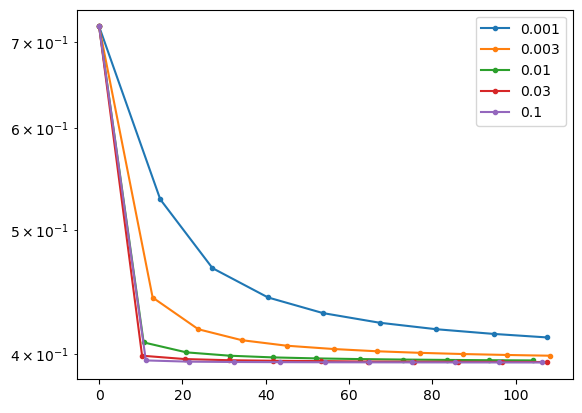

In [16]:
import matplotlib.pyplot as plt
for LR,(t,tr,tst) in logs.items():
	plt.plot(t,tr, '.-', label=str(LR))
plt.yscale('log')
plt.legend()

In [24]:
from sklearn.metrics import roc_auc_score
print('roc_auc_score:',roc_auc_score(y_tst, model(Xc_tst)[:, 1].cpu().detach().numpy()))

roc_auc_score: 0.7299710667967321


In [48]:
logs = {} # defaultdict(lambda : ([],[])) # time, train_loss

for LR in [0.01, 0.03, 0.1, 0.3, 1, 3, 10]:
	model = init_model(X_tr.shape[1])
	optimizer = optim.SGD(model.parameters(),
							lr=LR,
							#momentum=args.momentum,
							#weight_decay=1/C
							)

	logs[LR] = [[], []]

	t0 = time()
	for i,batch in tqdm(enumerate(get_batch_indexes(X_tr.shape[0], 32))):
		loss_value = loss(model(Xc_tr[batch]), yc_tr[batch])
		loss_value.backward()
		optimizer.step()
		optimizer.zero_grad()
		if i==0:
			mean_loss = loss_value.item()
		mean_loss = 0.95*mean_loss + 0.05*loss_value.item()
		if i%32==0:
			logs[LR][0].append(time()-t0)
			logs[LR][1].append(mean_loss)

	with torch.torch.no_grad():
		logs[LR].append(time()-t0)
		logs[LR].append(loss(model(Xc_tr), yc_tr).cpu().item())
		logs[LR].append(loss(model(Xc_tst), yc_tst).cpu().item())
		logs[LR].append(roc_auc_score(y_tst, model(Xc_tst)[:, 1].cpu().detach().numpy()))
		print(LR,logs[LR][2],logs[LR][3],logs[LR][4],logs[LR][5])


0it [00:00, ?it/s]

6727it [00:14, 462.97it/s]


0.01 14.554800033569336 0.40853339433670044 0.4089891314506531 0.7269422157591202


6727it [00:12, 523.83it/s]


0.03 12.859145641326904 0.398905873298645 0.39941126108169556 0.7289807125396236


6727it [00:13, 504.92it/s]


0.1 13.356801271438599 0.39555102586746216 0.3960723280906677 0.7295201659856757


6727it [00:11, 563.70it/s]


0.3 11.948768377304077 0.39443349838256836 0.39489665627479553 0.7293947627247647


6727it [00:12, 530.50it/s]


1 12.71774435043335 0.3940069079399109 0.3944932520389557 0.7280014983984802


6727it [00:12, 553.23it/s]


3 12.179141759872437 0.39390280842781067 0.39439669251441956 0.7249259139666383


6727it [00:12, 522.98it/s]

10 12.884685039520264 0.39385247230529785 0.39435940980911255 0.685500375823028


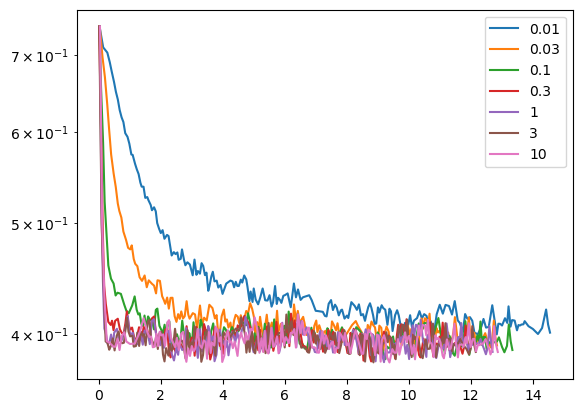

In [49]:
import matplotlib.pyplot as plt
for LR,log in logs.items():
	plt.plot(log[0],log[1], '-', label=str(LR))
plt.yscale('log')
plt.legend()

In [82]:
Q,R = torch.linalg.qr(Xc_tr)

In [56]:
logsQ = {} # defaultdict(lambda : ([],[])) # time, train_loss

for LR in [0.1, 1, 10, 100, 300, 1000]:
	model = init_model(X_tr.shape[1], bias=False)
	optimizer = optim.SGD(model.parameters(),
							lr=LR,
							#momentum=args.momentum,
							#weight_decay=1/C
							)

	logsQ[LR] = [[], []]

	t0 = time()
	for i,batch in tqdm(enumerate(get_batch_indexes(X_tr.shape[0], 32))):
		loss_value = loss(model(Q[batch]), yc_tr[batch])
		loss_value.backward()
		optimizer.step()
		optimizer.zero_grad()

		if i==0:
			mean_loss = loss_value.item()
		mean_loss = 0.95*mean_loss + 0.05*loss_value.item()
		if i%32==0:
			logsQ[LR][0].append(time()-t0)
			logsQ[LR][1].append(mean_loss)

	with torch.torch.no_grad():
		logsQ[LR].append(time()-t0)
		logsQ[LR].append(loss(model(Q), yc_tr).cpu().item())
		yc_pred = model(Xc_tst @torch.linalg.inv(R))
		logsQ[LR].append(loss(yc_pred, yc_tst).cpu().item())
		logsQ[LR].append(roc_auc_score(y_tst, yc_pred[:, 1].cpu().detach().numpy()))
		print(LR,logsQ[LR][2],logsQ[LR][3],logsQ[LR][4],logsQ[LR][5])


0it [00:00, ?it/s]

6727it [00:12, 550.03it/s]


0.1 12.275342226028442 0.6931397318840027 0.6931396722793579 0.5649553696834932


6727it [00:12, 554.91it/s]


1 12.140141487121582 0.6931095719337463 0.6931098103523254 0.6827495738396548


6727it [00:11, 567.62it/s]


10 11.880945444107056 0.6928171515464783 0.692815899848938 0.7346531484561342


6727it [00:11, 564.64it/s]


100 11.942799806594849 0.6903963685035706 0.6903846263885498 0.7355931882855611


6727it [00:11, 573.60it/s]


300 11.752336025238037 0.687261164188385 0.6872360110282898 0.7352472116757002


6727it [00:11, 571.77it/s]


1000 11.787897109985352 0.6842918395996094 0.6842519044876099 0.7337772665072658


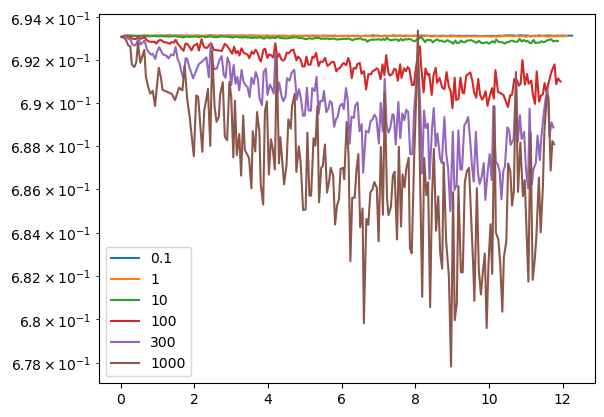

In [57]:
import matplotlib.pyplot as plt
for LR,log in logsQ.items():
	plt.plot(log[0],log[1], '-', label=str(LR))
plt.yscale('log')
plt.legend()

In [64]:
import optuna
study = optuna.create_study(sampler=None, direction='maximize')

def my_objective(trial: optuna.trial.Trial ):
	LR = trial.suggest_float('LR', 1, 1e5, log=True, step=None)
	shift = trial.suggest_float('shift', 1, 1e5, log=True, step=None)
	
	model = init_model(X_tr.shape[1], bias=False)
	optimizer = optim.SGD(model.parameters(),lr=LR)

	for i,batch in enumerate(get_batch_indexes(X_tr.shape[0], 32)):
		loss_value = loss(model(Q[batch]), yc_tr[batch])
		loss_value.backward()
		for param_group in optimizer.param_groups:
			param_group['lr'] = LR/(i+shift)
		optimizer.step()
		optimizer.zero_grad()

	yc_pred = model(Xc_tst @torch.linalg.inv(R))

	return roc_auc_score(y_tst, yc_pred[:, 1].cpu().detach().numpy())

study.optimize(my_objective, n_trials=100, n_jobs=3, gc_after_trial=True)

[I 2024-12-14 02:33:07,249] A new study created in memory with name: no-name-317e7563-8f4e-4942-9863-f58990d6d5d7
[I 2024-12-14 02:33:29,080] Trial 2 finished with value: 0.5434018949562995 and parameters: {'LR': 11.096638985094616, 'shift': 6.694341490843591}. Best is trial 2 with value: 0.5434018949562995.
[I 2024-12-14 02:33:30,619] Trial 1 finished with value: 0.5571352182287469 and parameters: {'LR': 220.26493944550302, 'shift': 1004.0747611440938}. Best is trial 1 with value: 0.5571352182287469.
[I 2024-12-14 02:33:32,817] Trial 0 finished with value: 0.5768130325623049 and parameters: {'LR': 4807.557722219868, 'shift': 28402.42895274436}. Best is trial 0 with value: 0.5768130325623049.
[I 2024-12-14 02:33:50,072] Trial 3 finished with value: 0.6512361029736942 and parameters: {'LR': 493.8094559877049, 'shift': 1.3165764721192392}. Best is trial 3 with value: 0.6512361029736942.
[I 2024-12-14 02:33:52,539] Trial 4 finished with value: 0.7207674011823804 and parameters: {'LR': 231

In [65]:
from optuna.visualization import plot_slice

plot_slice(study)

In [83]:
logsS = {} # defaultdict(lambda : ([],[])) # time, train_loss

for LR in [10_000, 100_000, 1_000_000]:
	model = init_model(X_tr.shape[1], bias=False)
	optimizer = optim.SGD(model.parameters(),
							lr=LR,
							#momentum=args.momentum,
							#weight_decay=1/C
							)

	logsS[LR] = [[], []]

	t0 = time()
	for i,batch in tqdm(enumerate(get_batch_indexes(X_tr.shape[0], 32))):
		loss_value = loss(model(Q[batch]), yc_tr[batch])
		loss_value.backward()
		for param_group in optimizer.param_groups:
			param_group['lr'] = LR/(i+1000)
		optimizer.step()
		optimizer.zero_grad()

		if i==0:
			mean_loss = loss_value.item()
		mean_loss = 0.95*mean_loss + 0.05*loss_value.item()
		if i%32==0:
			logsS[LR][0].append(time()-t0)
			logsS[LR][1].append(mean_loss)

	with torch.torch.no_grad():
		logsS[LR].append(time()-t0)
		logsS[LR].append(loss(model(Q), yc_tr).cpu().item())
		yc_pred = model(Xc_tst @torch.linalg.inv(R))
		logsS[LR].append(loss(yc_pred, yc_tst).cpu().item())
		logsS[LR].append(roc_auc_score(y_tst, yc_pred[:, 1].cpu().detach().numpy()))
		print(LR,logsS[LR][2],logsS[LR][3],logsS[LR][4],logsS[LR][5])

0it [00:00, ?it/s]

6727it [00:12, 553.92it/s]


10000 12.175981998443604 0.6930420994758606 0.6930422186851501 0.7255222937683468


6727it [00:12, 547.24it/s]


100000 12.31026840209961 0.692189633846283 0.6921856999397278 0.7356298226445234


6727it [00:12, 558.29it/s]


1000000 12.066084384918213 0.6872301697731018 0.6872046589851379 0.7356556049803594


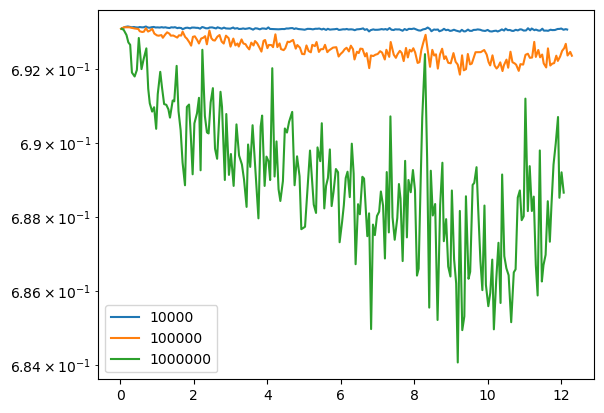

In [84]:
import matplotlib.pyplot as plt
for LR,log in logsS.items():
	plt.plot(log[0],log[1], '-', label=str(LR))
plt.yscale('log')
plt.legend()

In [68]:
i

6726

In [69]:
for LR in [10_000, 100_000, 1_000_000]:
	print(LR/(1000),LR/(i+1000))

10.0 1.2943308309603936
100.0 12.943308309603935
1000.0 129.43308309603935


In [86]:
print('direct with penalty: roc_auc_score:',roc_auc_score(y_tr, model(Xc_tr @torch.linalg.inv(R))[:, 1].cpu().detach().numpy()))
print('direct with penalty: roc_auc_score:',roc_auc_score(y_tst, model(Xc_tst @torch.linalg.inv(R))[:, 1].cpu().detach().numpy()))

direct with penalty: roc_auc_score: 0.7349244215418813
direct with penalty: roc_auc_score: 0.7356556049803594


# Тесты на вырожденном наборе данных

## загрузка и общая предобработка

In [1]:
# не меняем код
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150


data = pd.read_csv('application_train.csv')
data.columns = ['sk_id_curr', 'target'] + list(data.columns[2:])
data.head(3)

,sk_id_curr,target,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# не меняем код
test_idx = data.sk_id_curr % 10 >= 7
data_dict = dict()
data_dict['tst'] = data.loc[test_idx].reset_index(drop=True)
data_dict['tr'] = data.loc[~test_idx].reset_index(drop=True)

for key, df in data_dict.items():
    print(key, 'shape:', df.shape)

tst shape: (92221, 122)
tr shape: (215290, 122)


In [3]:
dtst = data_dict['tst'].drop(columns=['target', 'sk_id_curr']) # data test
dtr =  data_dict['tr'].drop(columns=['target', 'sk_id_curr']) # data train

ttst = data_dict['tst'].target # target test
ttr =  data_dict['tr'].target # target train

del data_dict
# учусь на (data_dict['tr'] , data_dict['tr'].target)
# тестируюсь на (data_dict['tst'] , data_dict['tst'].target)
# и у меня ROC_AUC == 1.0
# а почему?
# а потому что data_dict['tst'].target находится в data_dict['tst']
# 


In [4]:
onehot_columns = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_INCOME_TYPE', 'REGION_POPULATION_RELATIVE', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE', 
'HOUSETYPE_MODE', 'FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE']

In [5]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
	"""
	Отличается от обычного OneHotEncoder тем, что 
		NaN оставляет как есть
		работает с DataFrame и кодирует только заданные столбцы
	"""
	def __init__(self, columns):
		"""
		Инициализация encoder-а.
		
		:param columns: список имен столбцов для one-hot кодирования
		"""
		self.columns = columns
		self.unique_categories_ = {}

	def fit(self, X, y=None):
		"""
		Извлечение уникальных категорий для каждого столбца.
		
		:param X: DataFrame с данными для обучения
		:param y: Не используется, добавлено для совместимости
		:return: self
		"""
		for col in self.columns:
			self.unique_categories_[col] = X[col].dropna().unique()
		return self

	def transform(self, X):
		"""
		Преобразование DataFrame с one-hot кодированием указанных столбцов.
		
		:param X: DataFrame для преобразования
		:return: DataFrame с закодированными столбцами
		"""
		one_hot_dfs = []

		for col in self.columns:
			categories = self.unique_categories_[col]

			# Создаем one-hot кодирование для текущего столбца
			one_hot = pd.DataFrame(
				{f"{col}=={cat}": (X[col] == cat).astype(float) for cat in categories[1:]}, # drop='first'
				index=X.index
			)

			# Заменяем строки с NaN в оригинальном столбце на NaN в one-hot кодировке
			one_hot[X[col].isna()] = np.nan

			# Добавляем закодированный DataFrame в список
			one_hot_dfs.append(one_hot)

		# Объединяем оригинальный DataFrame (без кодируемых столбцов) и закодированные
		X = X.drop(columns=self.columns, axis=1).join(pd.concat(one_hot_dfs, axis=1))
		return X


In [6]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class MissingIndicator(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        Инициализация класса. Не требует параметров.
        """
        self.columns_with_nan_ = []

    def fit(self, X, y=None):
        """
        Находит столбцы с NaN и запоминает их.

        :param X: DataFrame для анализа
        :param y: Не используется, добавлено для совместимости
        :return: self
        """
        self.columns_with_nan_ = X.columns[X.isna().values.any(axis=0)]   #    [col for col in X.columns if X[col].isna().any()]
        return self

    def transform(self, X):
        """
        Добавляет индикаторные столбцы для запомненных столбцов с NaN.

        :param X: DataFrame для преобразования
        :return: DataFrame с добавленными индикаторными столбцами
        """
        X = X.copy()
        for col in self.columns_with_nan_:
            X[f"{col}_missing"] = X[col].isna().astype(float)
        return X


In [7]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class PdToNp(BaseEstimator, TransformerMixin):
	def __init__(self):
		pass

	def fit(self, X, y=None):
		return self

	def transform(self, X):
		return X.values


In [11]:
# Создание пайплайна
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

trans_pipeline = Pipeline(steps=[
    ('missing_indicator', MissingIndicator()),
    ('one_hot_encoder', CustomOneHotEncoder(columns=onehot_columns)),
	('to_np', PdToNp()),
	('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
])


In [12]:
#X_tr, X_tst = data_dict["tr"][features].to_numpy(), data_dict["tst"][features].to_numpy()
y_tr, y_tst = ttr.to_numpy(), ttst.to_numpy()

trans_pipeline.fit(dtr)

X_tr = trans_pipeline.transform(dtr)
X_tst = trans_pipeline.transform(dtst)


## распределение сингулярных значений

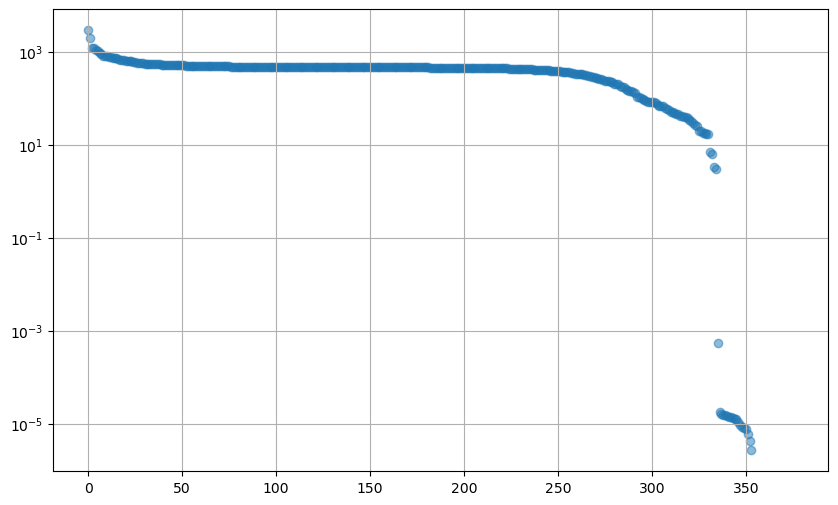

C:\Users\FeelUs\AppData\Local\Temp\ipykernel_3872\1056397218.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  s1[0], s1[-1], s1[0]/s1[-1]


(2895.9956188414503, 0.0, inf)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

pca = PCA(n_components=None)
pca.fit(X_tr)
s1 = pca.singular_values_


plt.figure(figsize=(10,6))
plt.scatter(x=[i for i in range(len(s1))],  y=s1 ,alpha=0.5)
plt.grid()
plt.yscale('log')
plt.show()

s1[0], s1[-1], s1[0]/s1[-1]
#32s

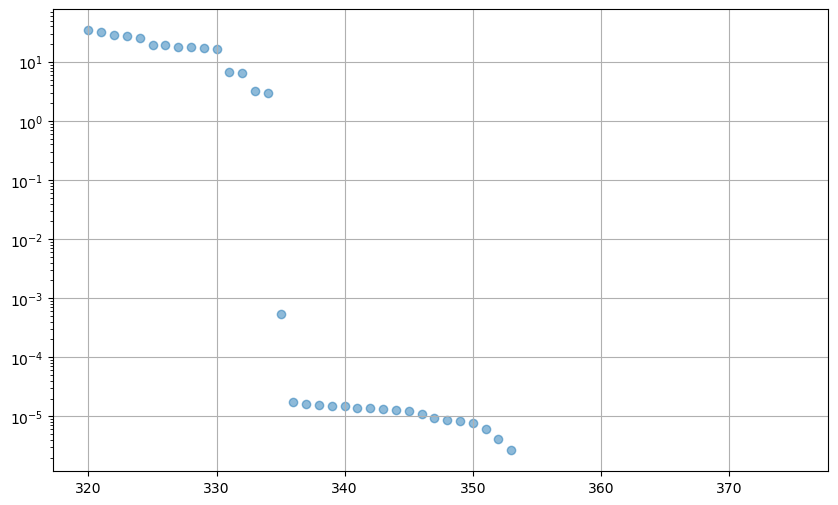

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i for i in range(320,len(s1))],  y=s1[320:] ,alpha=0.5)
plt.grid()
plt.yscale('log')
plt.show()

In [ ]:
s1[350:]

array([7.71009698e-06, 6.02006898e-06, 4.14714149e-06, 2.66320409e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

## эксперименты

### 1 pipeline with QR_regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Создание пайплайна
qr_pipeline = Pipeline(steps=[
    ('missing_indicator', MissingIndicator()),
    ('one_hot_encoder', CustomOneHotEncoder(columns=onehot_columns)),
	('to_np', PdToNp()),
	('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
	('logreg',QR_regression(solver='lbfgs', tol=1e-8))
])


In [ ]:
qr_pipeline.fit(dtr,ttr)
#3m42s

c:\Users\FeelUs\miniforge3\envs\nout\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('missing_indicator', MissingIndicator()),
                ('one_hot_encoder',
                 CustomOneHotEncoder(columns=['NAME_CONTRACT_TYPE',
                                              'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                                              'REGION_RATING_CLIENT',
                                              'REGION_RATING_CLIENT_W_CITY',
                                              'CODE_GENDER',
                                              'NAME_EDUCATION_TYPE',
                                              'NAME_FAMILY_STATUS',
                                              'NAME_HOUSING_TYPE',
                                              'WEEKDAY_APPR_PROCESS_START',
                                              'NAME_INCOME_TYPE',
                                              'REGION_POPULATION_RELATIVE',
                                              'ORGANIZATION_TYPE',
                                              'EMERGENCYSTATE_MODE',
                                              'HOUSETYPE_MODE',
                                              'FONDKAPREMONT_MODE',
                                              'WALLSMATERIAL_MODE',
                                              'NAME_TYPE_SUITE',
                                              'OCCUPATION_TYPE'])),
                ('to_np', PdToNp()), ('imputer', SimpleImputer()),
                ('scaler', StandardScaler()), ('logreg', QR_regression())])

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ttst, qr_pipeline.predict_proba(dtst)[:, 1])

0.4882247837665921

### manual QR_regression

In [ ]:
X1  = np.hstack([np.ones((X_tr.shape[0],1)),X_tr])
Q,R = np.linalg.qr(X1)
#2m11s


In [ ]:

print('orthogonality:',np.linalg.norm(Q.T @ Q - np.eye(Q.shape[1])))
#34s

orthogonality: 2.549841098958257e-12


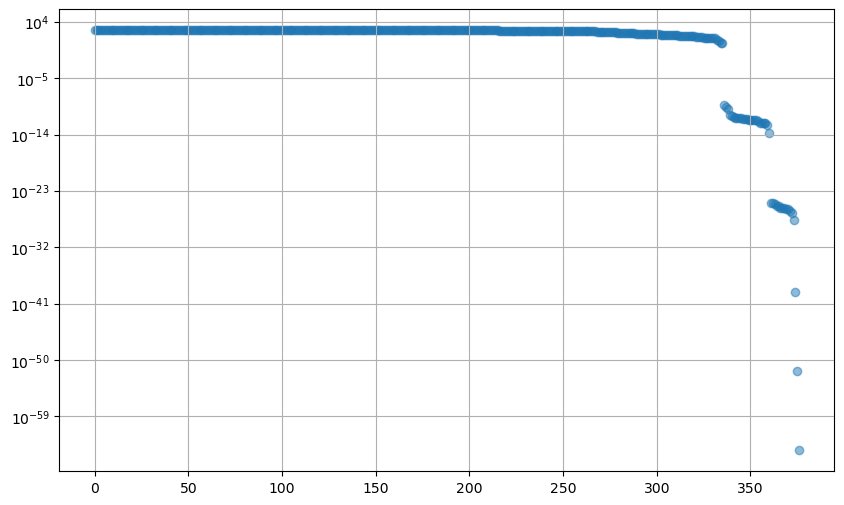

In [ ]:
d = sorted(np.abs(np.diag(R)), reverse=True)

plt.figure(figsize=(10,6))
plt.scatter(x=[i for i in range(len(d))],  y=d ,alpha=0.5)
plt.grid()
plt.yscale('log')
plt.show()

In [ ]:
Q_model = LogisticRegression(solver='lbfgs', fit_intercept=False,penalty=None,tol=1e-8, max_iter=1000)
Q_model.fit(Q, y_tr)
#59s

LogisticRegression(fit_intercept=False, max_iter=1000, penalty=None, tol=1e-08)

In [ ]:
X_tr.shape, X1.shape, Q.shape

((215290, 376), (215290, 377), (215290, 377))

In [ ]:
w = (splin.solve_triangular(R, Q_model.coef_.T, lower=False)).T[0]
#w = (np.linalg.inv(R)@Q_model.coef_.T).T[0]

print(w.shape)

X_model = LogisticRegression()
X_model.coef_ = w[None,1:]
X_model.intercept_ = w[0:1]
X_model.classes_ = np.array([0, 1])

print('roc_auc_score:',roc_auc_score(y_tst, X_model.predict_proba(X_tst)[:, 1]))

(377,)
roc_auc_score: 0.5110863791521183


#### попробуем вырезать сингулярные строки

In [ ]:
d = np.abs(np.diag(R))
np.fill_diagonal(R,0)
dd = np.linalg.norm(R,ord=np.inf, axis=0)
ddd = np.linalg.norm(R,ord=np.inf, axis=1)
np.fill_diagonal(R,d)
(1e6*d < dd).astype(int).sum()

41

In [ ]:
Q_model.coef_[:,1e6*d < dd]

array([[   3.07235935,  145.70820169,   -2.50842188,   -6.70242381,
          71.17400326,  -56.6631765 ,   37.70288501,   11.89045647,
         -12.60763996,  155.83172976,  -20.9305219 ,  -54.71995107,
          -1.19685368,  -28.40500856,  -11.29217456,   -7.7957918 ,
         -11.02891174,   42.08801245, -113.60416628,   95.4022382 ,
          -2.35031589,  169.66644812,   -9.3446849 ,    1.6164872 ,
        -295.88792221,  170.75736058,  199.12832726, -162.27555346,
          88.34735908,  -18.47425312,  257.9460138 ,   -6.60642306,
           2.86391704,  -13.09860033,    8.00567841, -110.31939245,
        -171.37039745,    4.22425246,   -4.81914374,  -32.29741442,
           6.12023954]])

In [ ]:
len(d)

377

In [ ]:
ddd[1e6*d < dd]

array([ 6.29008736,  6.62064917,  6.80671823,  7.88373724,  8.53854588,
        6.74788892,  6.38089072,  7.41616049,  8.93287973,  9.26273198,
       13.05002377,  6.33234026,  7.68073459,  4.88643977,  4.92734306,
        3.50894713,  4.22019807,  8.87515244, 15.84016193, 16.8959338 ,
        9.57264876,  6.57073264, 11.36965761,  4.5002341 , 15.50313131,
       11.42724168,  7.05132457,  4.84252967, 11.7871148 , 12.42297245,
        6.57668567,  9.61391311,  3.81632788,  8.99234403, 16.6241552 ,
        3.9014498 ,  5.5320791 , 21.2293749 , 14.96082688,  5.28003608,
        5.89827304])

In [ ]:
w = (splin.solve_triangular(R[1e6*d > dd,:][:,1e6*d > dd], Q_model.coef_[:,1e6*d > dd].T, lower=False)).T[0]
#w = (np.linalg.inv(R)@Q_model.coef_.T).T[0]

print(w.shape)

X_model = LogisticRegression()
X_model.coef_ = w[None,:]
X_model.intercept_ = 0
X_model.classes_ = np.array([0, 1])

print('roc_auc_score:',roc_auc_score(y_tst, X_model.predict_proba(np.hstack([np.ones((X_tst.shape[0],1)),X_tst])[:,1e6*d > dd])[:, 1]))

(336,)
roc_auc_score: 0.501910384657612


In [ ]:
w = (splin.solve_triangular(R, Q_model.coef_.T, lower=False)).T[0]
#w = (np.linalg.inv(R)@Q_model.coef_.T).T[0]

print(w.shape)

X_model = LogisticRegression()
X_model.coef_ = w[None,1e6*d > dd]
X_model.intercept_ = 0
X_model.classes_ = np.array([0, 1])

print('roc_auc_score:',roc_auc_score(y_tst, X_model.predict_proba(np.hstack([np.ones((X_tst.shape[0],1)),X_tst])[:,1e6*d > dd])[:, 1]))

(377,)
roc_auc_score: 0.5330527958936431


### manual QR_regression с вырезанием столбцов

In [ ]:
X1  = np.hstack([np.ones((X_tr.shape[0],1)),X_tr])
Q,R = np.linalg.qr(X1)
#2m19s

In [ ]:
d = np.abs(np.diag(R))
np.fill_diagonal(R,0)
dd = np.linalg.norm(R,ord=np.inf, axis=0)
(1e6*d < dd).astype(int).sum()

41

In [ ]:
(d<1e-5).astype(int).sum()

41

In [ ]:
XX1 = X1[:,1e6*d > dd]

Q,R = np.linalg.qr(XX1)
#1m48s

In [ ]:

Q_model = LogisticRegression(solver='lbfgs', fit_intercept=False,penalty=None,tol=1e-8, max_iter=1000)
Q_model.fit(Q, y_tr)

w = (splin.solve_triangular(R, Q_model.coef_.T, lower=False)).T[0]
#w = (np.linalg.inv(R)@Q_model.coef_.T).T[0]

print(w.shape)
#8s

(336,)


In [ ]:

X_model = LogisticRegression(fit_intercept=False)
X_model.coef_ = w[None,:]
X_model.intercept_ = 0
X_model.classes_ = np.array([0, 1])

print('roc_auc_score:',roc_auc_score(y_tst, X_model.predict_proba(np.hstack([np.ones((X_tst.shape[0],1)),X_tst])[:,1e6*d > dd])[:, 1]))

roc_auc_score: 0.7503903152816991


### PCA_norm(n_components=335)

In [ ]:
pca_norm = PCA_norm(n_components=335)
QP = pca_norm.fit_transform(X_tr)
#1m32s

In [ ]:
print('orthogonality:',np.linalg.norm(QP.T @ QP - np.eye(QP.shape[1])))
#28s

orthogonality: 1.054769691765473e-07


In [ ]:
QP_model = LogisticRegression(solver='lbfgs', fit_intercept=False,penalty=None,tol=1e-8, max_iter=1000)
QP_model.fit(QP, y_tr)
#9s

LogisticRegression(fit_intercept=False, max_iter=1000, penalty=None, tol=1e-08)

In [ ]:
print('roc_auc_score:',roc_auc_score(y_tst, QP_model.predict_proba(pca_norm.transform(X_tst))[:, 1]))
#13s

roc_auc_score: 0.7503901463724731


### normPCA_regression

In [53]:
model = normPCA_regression()
model.fit(X_tr, y_tr)

normPCA_regression()

In [54]:
print('roc_auc_score:',roc_auc_score(y_tst, model.predict_proba(X_tst)[:, 1]))

roc_auc_score: 0.7503901463724731


In [55]:
print('roc_auc_score:',roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1]))

roc_auc_score: 0.7524980634832725


### direct

In [ ]:
X_model = LogisticRegression(solver='newton-cholesky', tol=1e-8, max_iter=500)
X_model.fit(X_tr, y_tr)
print('direct with penalty: roc_auc_score:',roc_auc_score(y_tst, X_model.predict_proba(X_tst)[:, 1]))
#10m50s

direct with penalty: roc_auc_score: 0.7501072960340193


## результаты
|метод                                             | время               | roc_auc |
|------                                            |-------              |----------|
|QR full, <!--maxiter=1000-->                      | 2m19s+59s+0s        | 0.5110863791521183  |
|QR+QR with cut, <!--maxiter=1000-->               | (2m19s+1m57s)+8s+0s | 0.7503903152816991  |
|PCA+PCA_norm(n_components=335) <!--maxiter=500--> | (32s+1m32s)+9s+12s  | 0.7503901463724731  |
| normPCA_regression                               | 1m18s               | 0.7503901463724731  |
|direct, <!--maxiter=500-->                        | 0s+10m50s+0s        | 0.7501072960340193  |
<!--|QR full, maxiter=100 | не сошлось, 3m42s | 0.4882247837665921  |-->


## torch, SGD, multilayer nn

In [16]:
import torch
from torch import nn
import torch.optim as optim

In [ ]:
pca_norm = PCA_norm(n_components=335)
Q_tr = pca_norm.fit_transform(X_tr)
Q_tst = pca_norm.transform(X_tst)

In [43]:
u,s,v = np.linalg.svd(X_tr,full_matrices=False)
s[0]/s[-1]

1.2083483179404226e+17

In [44]:
u,s,v = np.linalg.svd(Q_tr,full_matrices=False)
s[0]/s[-1]

1.0000000586182793

In [58]:
from sklearn.linear_model import LogisticRegression
X_model = LogisticRegression(fit_intercept=False, penalty=None, solver='lbfgs', tol=1e-8, max_iter=500)
X_model.fit(Q_tr, y_tr)
print('direct with penalty: roc_auc_score:',roc_auc_score(y_tr, X_model.predict_proba(Q_tr)[:, 1]))
print('direct with penalty: roc_auc_score:',roc_auc_score(y_tst, X_model.predict_proba(Q_tst)[:, 1]))


direct with penalty: roc_auc_score: 0.7524980634832725
direct with penalty: roc_auc_score: 0.7503901463724731


In [ ]:
device = torch.device("cuda:0")

Xc_tr = torch.tensor(X_tr, device=device, requires_grad=False, dtype=torch.float32)
Qc_tr = torch.tensor(Q_tr, device=device, requires_grad=False, dtype=torch.float32)
yc_tr = torch.tensor(y_tr/2+0.5, device=device, requires_grad=False, dtype=torch.long)

Xc_tst = torch.tensor(X_tst, device=device, requires_grad=False, dtype=torch.float32)
Qc_tst = torch.tensor(Q_tst, device=device, requires_grad=False, dtype=torch.float32)
yc_tst = torch.tensor(y_tst/2+0.5, device=device, requires_grad=False, dtype=torch.long)

In [77]:
model = init(LogRegModel,Qc_tr.shape[1],bias=False)
print('direct with penalty: roc_auc_score:',roc_auc_score(y_tr, model(Qc_tr)[:, 1].cpu().detach().numpy()))
print('direct with penalty: roc_auc_score:',roc_auc_score(y_tst, model(Qc_tst)[:, 1].cpu().detach().numpy()))
train1epoch(Qc_tr,yc_tr,Qc_tst,yc_tst,model,0.01)

direct with penalty: roc_auc_score: 0.46891269353883913
direct with penalty: roc_auc_score: 0.47053625916737063


loss=0.69314: 100%|██████████| 6727/6727 [00:13<00:00, 512.36it/s]


{'time_log': [0.0204164981842041,
  0.08827900886535645,
  0.15494608879089355,
  0.2228708267211914,
  0.2773432731628418,
  0.3341975212097168,
  0.3920283317565918,
  0.44866275787353516,
  0.5150487422943115,
  0.57781982421875,
  0.6317400932312012,
  0.6923625469207764,
  0.7405095100402832,
  0.8081128597259521,
  0.8644163608551025,
  0.9174823760986328,
  0.9676003456115723,
  1.0339007377624512,
  1.0966269969940186,
  1.1551246643066406,
  1.2101225852966309,
  1.2701263427734375,
  1.3238375186920166,
  1.3807196617126465,
  1.4341869354248047,
  1.5168869495391846,
  1.5845866203308105,
  1.6507604122161865,
  1.7112488746643066,
  1.7602334022521973,
  1.8229336738586426,
  1.8698859214782715,
  1.9843158721923828,
  2.091845750808716,
  2.1948108673095703,
  2.304117441177368,
  2.358031988143921,
  2.414802074432373,
  2.475181818008423,
  2.533992052078247,
  2.590235948562622,
  2.6550471782684326,
  2.7153544425964355,
  2.7670133113861084,
  2.8294711112976074,
  2.

In [69]:
print('direct with penalty: roc_auc_score:',roc_auc_score(y_tr, model(Qc_tr)[:, 1].cpu().detach().numpy()))

direct with penalty: roc_auc_score: 0.4715329446614248


In [ ]:
from time import time
from tqdm import tqdm

logs = {} # defaultdict(lambda : ([],[],[],[])) # time, train_loss, test_loss, test_rocauc

for LR in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
	print('LR:',LR)
	model = init(Qc_tr.shape[1],100)
	optimizer = optim.SGD(model.parameters(),
							lr=LR,
							#momentum=args.momentum,
							#weight_decay=1/C
							)

	with torch.torch.no_grad():
		train_loss = loss(model(Qc_tr), yc_tr).cpu().item()
		y_pred = model(Qc_tst)
		test_loss  = loss(y_pred, yc_tst).cpu().item()
		test_rocauc = roc_auc_score(y_tst, y_pred[:, 1].cpu().detach().numpy())
	t0 = time()
	logs[LR] = ([time()-t0], [train_loss], [test_loss], [test_rocauc])
	print(len(logs[LR][0])-1,logs[LR][0][-1],logs[LR][1][-1],logs[LR][2][-1],logs[LR][3][-1])

	timer = 100
	test_time = 0
	#with tqdm(total=timer, desc="Progress", unit="s") as pbar:
	while time() - t0 - test_time < timer:
		for batch in get_batch_indexes(Qc_tr.shape[0], 32):
			loss_value = loss(model(Qc_tr[batch]), yc_tr[batch])
			loss_value.backward()
			optimizer.step()
			optimizer.zero_grad()
		t1 = time()
		with torch.torch.no_grad():
			logs[LR][0].append(t1-t0-test_time)
			logs[LR][1].append(loss(model(Qc_tr), yc_tr).cpu().item())
			y_pred = model(Qc_tst)
			logs[LR][2].append(loss(y_pred, yc_tst).cpu().item())
			logs[LR][3].append(roc_auc_score(y_tst, y_pred[:, 1].cpu().detach().numpy()))
			print(len(logs[LR][0])-1,logs[LR][0][-1],logs[LR][1][-1],logs[LR][2][-1],logs[LR][3][-1])
		test_time += time()-t1
		#pbar.update(min(1, time() - t0 - test_time))


LR: 0.001
0 0.0 0.6756954193115234 0.6757062673568726 0.51378963634554
1 15.790879726409912 0.5125389099121094 0.5127890110015869 0.5141312773555003
2 30.823927879333496 0.462602436542511 0.4629085958003998 0.5143426459409258
3 46.135018825531006 0.4414219558238983 0.44179925322532654 0.5144725331892817
4 62.03440499305725 0.4300670623779297 0.43045634031295776 0.5145815917200381
5 77.79815292358398 0.4230201840400696 0.4234371781349182 0.5146566908141085
6 93.67358732223511 0.4182647168636322 0.41868987679481506 0.5147298032515342
7 109.65130972862244 0.41485363245010376 0.41526609659194946 0.5147772028111232
LR: 0.01
0 0.0 0.6756954193115234 0.6757062673568726 0.51378963634554
1 15.570101737976074 0.40858983993530273 0.4090391993522644 0.5149445034530492
2 31.056591272354126 0.4012337625026703 0.40170520544052124 0.5152259835746038
3 46.885510206222534 0.3988102674484253 0.3992570638656616 0.5153352236433136
4 62.26994705200195 0.3975566625595093 0.39801332354545593 0.515444245866479

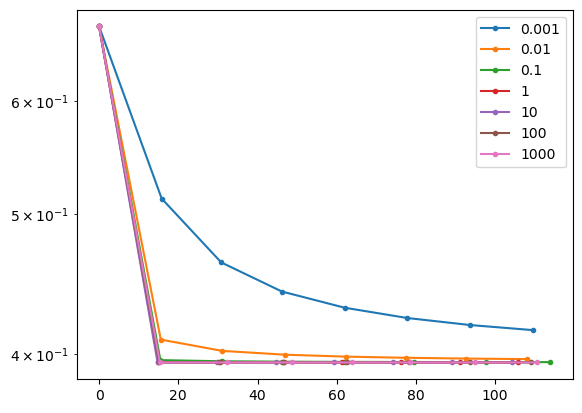

In [30]:
import matplotlib.pyplot as plt
for LR,(t,tr,tst,roc) in logs.items():
	plt.plot(t,tst, '.-', label=str(LR))
plt.yscale('log')
plt.legend()

In [36]:
from time import time
from tqdm import tqdm

logs = {} # defaultdict(lambda : ([],[],[],[])) # time, train_loss, test_loss, test_rocauc

for LR in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
	print('LR:',LR)
	model = init_model(Qc_tr.shape[1],10)
	optimizer = optim.SGD(model.parameters(),
							lr=LR,
							#momentum=args.momentum,
							#weight_decay=1/C
							)

	with torch.torch.no_grad():
		train_loss = loss(model(Qc_tr), yc_tr).cpu().item()
		y_pred = model(Qc_tst)
		test_loss  = loss(y_pred, yc_tst).cpu().item()
		test_rocauc = roc_auc_score(y_tst, y_pred[:, 1].cpu().detach().numpy())
	t0 = time()
	logs[LR] = ([time()-t0], [train_loss], [test_loss], [test_rocauc])
	print(len(logs[LR][0])-1,logs[LR][0][-1],logs[LR][1][-1],logs[LR][2][-1],logs[LR][3][-1])

	timer = 100
	test_time = 0
	#with tqdm(total=timer, desc="Progress", unit="s") as pbar:
	while time() - t0 - test_time < timer:
		for batch in get_batch_indexes(Qc_tr.shape[0], 32):
			loss_value = loss(model(Qc_tr[batch]), yc_tr[batch])
			loss_value.backward()
			optimizer.step()
			optimizer.zero_grad()
		t1 = time()
		with torch.torch.no_grad():
			logs[LR][0].append(t1-t0-test_time)
			logs[LR][1].append(loss(model(Qc_tr), yc_tr).cpu().item())
			y_pred = model(Qc_tst)
			logs[LR][2].append(loss(y_pred, yc_tst).cpu().item())
			logs[LR][3].append(roc_auc_score(y_tst, y_pred[:, 1].cpu().detach().numpy()))
			print(len(logs[LR][0])-1,logs[LR][0][-1],logs[LR][1][-1],logs[LR][2][-1],logs[LR][3][-1])
		test_time += time()-t1
		#pbar.update(min(1, time() - t0 - test_time))


LR: 0.001
0 0.0 0.6536991596221924 0.6537436842918396 0.5117282965654519
1 17.336511611938477 0.5062084794044495 0.506466805934906 0.511781300912023
2 32.52008533477783 0.4602324664592743 0.4605429768562317 0.5118144868391693
3 50.011770248413086 0.4402692914009094 0.4406195878982544 0.5118393843748075
4 69.09394407272339 0.4293910562992096 0.4297548532485962 0.5118602896540653
5 87.3453426361084 0.4225994646549225 0.4229779839515686 0.5118748655731189
6 107.75297522544861 0.41797125339508057 0.41836118698120117 0.5118953998835158
LR: 0.01
0 0.0 0.6536991596221924 0.6537436842918396 0.5117282965654519
1 19.689632654190063 0.40848883986473083 0.40891313552856445 0.5119344447507788
2 38.92228627204895 0.4012283682823181 0.40167465806007385 0.5119971771637568
3 61.16679501533508 0.39879876375198364 0.39923009276390076 0.5120473968759844
4 81.08279085159302 0.3975524306297302 0.39800959825515747 0.5119823944492955
5 101.58415603637695 0.39680442214012146 0.3972824513912201 0.51205331738114

In [35]:
from time import time
from tqdm import tqdm

logs = {} # defaultdict(lambda : ([],[],[],[])) # time, train_loss, test_loss, test_rocauc

for LR in [0.001, 0.01, 0.1, 1, 10]:
	print('LR:',LR)
	model = init_model(Qc_tr.shape[1],1000)
	optimizer = optim.SGD(model.parameters(),
							lr=LR,
							#momentum=args.momentum,
							#weight_decay=1/C
							)

	with torch.torch.no_grad():
		train_loss = loss(model(Qc_tr), yc_tr).cpu().item()
		y_pred = model(Qc_tst)
		test_loss  = loss(y_pred, yc_tst).cpu().item()
		test_rocauc = roc_auc_score(y_tst, y_pred[:, 1].cpu().detach().numpy())
	t0 = time()
	logs[LR] = ([time()-t0], [train_loss], [test_loss], [test_rocauc])
	print(len(logs[LR][0])-1,logs[LR][0][-1],logs[LR][1][-1],logs[LR][2][-1],logs[LR][3][-1])

	timer = 100
	test_time = 0
	#with tqdm(total=timer, desc="Progress", unit="s") as pbar:
	while time() - t0 - test_time < timer:
		for batch in get_batch_indexes(Qc_tr.shape[0], 32):
			loss_value = loss(model(Qc_tr[batch]), yc_tr[batch])
			loss_value.backward()
			optimizer.step()
			optimizer.zero_grad()
		t1 = time()
		with torch.torch.no_grad():
			logs[LR][0].append(t1-t0-test_time)
			logs[LR][1].append(loss(model(Qc_tr), yc_tr).cpu().item())
			y_pred = model(Qc_tst)
			logs[LR][2].append(loss(y_pred, yc_tst).cpu().item())
			logs[LR][3].append(roc_auc_score(y_tst, y_pred[:, 1].cpu().detach().numpy()))
			print(len(logs[LR][0])-1,logs[LR][0][-1],logs[LR][1][-1],logs[LR][2][-1],logs[LR][3][-1])
		test_time += time()-t1
		#pbar.update(min(1, time() - t0 - test_time))


LR: 0.001
0 0.0 0.696986973285675 0.6969813704490662 0.4858768034513048
1 20.44960069656372 0.5187891721725464 0.5190061330795288 0.48792768190951397
2 41.83087611198425 0.464868426322937 0.4651751220226288 0.4889563375175727
3 63.32465100288391 0.4425394833087921 0.4428997337818146 0.48957954152510985
4 84.19670128822327 0.4307028353214264 0.43109461665153503 0.49005079826579157
5 104.68599343299866 0.4234660267829895 0.4238530099391937 0.49040921653981245
LR: 0.01
0 0.0 0.696986973285675 0.6969813704490662 0.4858768034513048
1 20.142064094543457 0.40870481729507446 0.4091361165046692 0.4916784849189713
2 42.123385190963745 0.40127572417259216 0.4017268419265747 0.4928754735674031
3 62.83088779449463 0.3988100588321686 0.3992624580860138 0.4935079099638052
4 80.0971167087555 0.39759373664855957 0.3980225622653961 0.4940232378051682
5 95.61142444610596 0.39680376648902893 0.3972877860069275 0.49438973215022153
6 111.0758728981018 0.39633888006210327 0.39677873253822327 0.49461373025212

In [37]:


def init_model(n, bias=True):
	"""
	:param n: int, input size for Linear Model
	:return: Linear Model with input size n
	"""
	torch.manual_seed(0)
	return LogRegModel(n, bias)

def get_batch_indexes(n, batch_size):
	"""
	:param batch_size: int, batch size
	:param n: int, the size of full dataset
	:return: list of batches
	"""
	indexes = np.arange(n)
	#indexes = np.random.permutation(indexes)
	batches = np.array_split(indexes, n//batch_size)
	return batches


loss = nn.CrossEntropyLoss()


In [40]:
logsQ = {} # defaultdict(lambda : ([],[])) # time, train_loss

for LR in [0.1, 1, 10, 100, 300, 1000]:
	model = init_model(Qc_tr.shape[1], bias=False)
	optimizer = optim.SGD(model.parameters(),
							lr=LR,
							#momentum=args.momentum,
							#weight_decay=1/C
							)

	logsQ[LR] = [[], []]

	t0 = time()
	for i,batch in tqdm(enumerate(get_batch_indexes(Qc_tr.shape[0], 32))):
		loss_value = loss(model(Qc_tr[batch]), yc_tr[batch])
		loss_value.backward()
		optimizer.step()
		optimizer.zero_grad()

		if i==0:
			mean_loss = loss_value.item()
		mean_loss = 0.95*mean_loss + 0.05*loss_value.item()
		if i%32==0:
			logsQ[LR][0].append(time()-t0)
			logsQ[LR][1].append(mean_loss)

	with torch.torch.no_grad():
		logsQ[LR].append(time()-t0)
		logsQ[LR].append(loss(model(Qc_tr), yc_tr).cpu().item())
		yc_pred = model(Qc_tst)
		logsQ[LR].append(loss(yc_pred, yc_tst).cpu().item())
		logsQ[LR].append(roc_auc_score(y_tst, yc_pred[:, 1].cpu().detach().numpy()))
		print(LR,logsQ[LR][2],logsQ[LR][3],logsQ[LR][4],logsQ[LR][5])


0it [00:00, ?it/s]

6727it [00:16, 419.45it/s]


0.1 16.089059114456177 0.6930100917816162 0.6930103898048401 0.49670238044403714


6727it [00:14, 472.17it/s]


1 14.266584873199463 0.6917428374290466 0.6917439103126526 0.6688571183438814


6727it [00:14, 477.11it/s]


10 14.11621904373169 0.6793150901794434 0.6793330907821655 0.7473992770211546


6727it [00:14, 478.26it/s]


100 14.08306336402893 0.582222044467926 0.5823765993118286 0.7482484626300572


6727it [00:13, 480.81it/s]


300 14.007325172424316 0.48753342032432556 0.4878391623497009 0.7478390969134049


6727it [00:13, 511.53it/s]


1000 13.174668550491333 0.42432016134262085 0.4247426986694336 0.7471065218141135


In [42]:
yc_pred = model(Qc_tst)
roc_auc_score(yc_tst.cpu().detach().numpy(), yc_pred[:, 1].cpu().detach().numpy())

0.7471065218141135